# mmWave Vital Reconstruction — Processing Pipeline

## Overview
原始 JSON → 提取 x,y,z → 計算 range → 均勻重取樣 (~20 Hz) → 線性去趨勢 →  
分支：呼吸 (0.1–0.5 Hz) 與心跳 (0.8–3.0 Hz) → 峰值檢測 → 速率估計 → 輸出與視覺化

---

## Steps

1. **原始 JSON 資料**
   - 逐檔解析 `data[].frameData`。
   - 讀取 `timestamp`（毫秒）與 `trackData`。

2. **提取 x, y, z 座標**
   - 取第一個有效 track。
   - 取得三維位置 `(x, y, z)`（單位：公尺）。

3. **計算目標距離（range）**
   - \( r(t) = \sqrt{x^2 + y^2 + z^2} \)。

4. **重新取樣成均勻時間序列（~20 Hz）**
   - 由時間戳估計取樣率。
   - 線性插值到均勻時間軸 \( t_u \)。

5. **線性去趨勢**
   - 對 \( r(t_u) \) 執行線性去趨勢，得 \( r_d(t_u) \)。

6. **分支處理**
   - **呼吸帶通濾波**：Butterworth，0.1–0.5 Hz → 得 \( r_{\text{resp}} \)  
     **峰值檢測**：設置最小峰距與顯著性  
     **呼吸率估計**：以相鄰峰間距中位數換算 BPM
   - **心跳帶通濾波**：Butterworth，0.8–3.0 Hz → 得 \( r_{\text{heart}} \)  
     **峰值檢測**：同上（頻帶對應的最小峰距）  
     **心率估計**：以相鄰峰間距中位數換算 BPM

7. **輸出結果**
   - 表格：取樣率、時長、呼吸率 BPM、心率 BPM。
   - CSV：`t_sec, range_detrended, respiration, heartbeat`。
   - 視覺化：呼吸與心跳波形圖。

---

## Notes
- 這是位移導出的替代波形（BCG/PPG-like），非臨床 ECG。
- 品質受姿勢、距離、遮擋與追蹤穩定度影響。
- 若裝置提供相位訊號，可改用相位差提升微位移靈敏度。


Found 3 files:
  - replay_1.json
  - replay_2.json
  - replay_3.json


統計資訊
總資料點數: 270
最大振幅: 1.1599
最小振幅: -1.0774
平均振幅: 0.0050
標準差: 0.4123

檔案詳情:
------------------------------------------------------------

檔案: replay_1.json
  資料點: 90
  Frame數: 6
  索引範圍: [0, 90)
  平均心率: 56.08 bpm
  心率範圍: 50.22 - 68.64 bpm

檔案: replay_2.json
  資料點: 90
  Frame數: 6
  索引範圍: [90, 180)
  平均心率: 63.34 bpm
  心率範圍: 55.25 - 70.31 bpm

檔案: replay_3.json
  資料點: 90
  Frame數: 6
  索引範圍: [180, 270)
  平均心率: 62.50 bpm
  心率範圍: 56.92 - 63.62 bpm


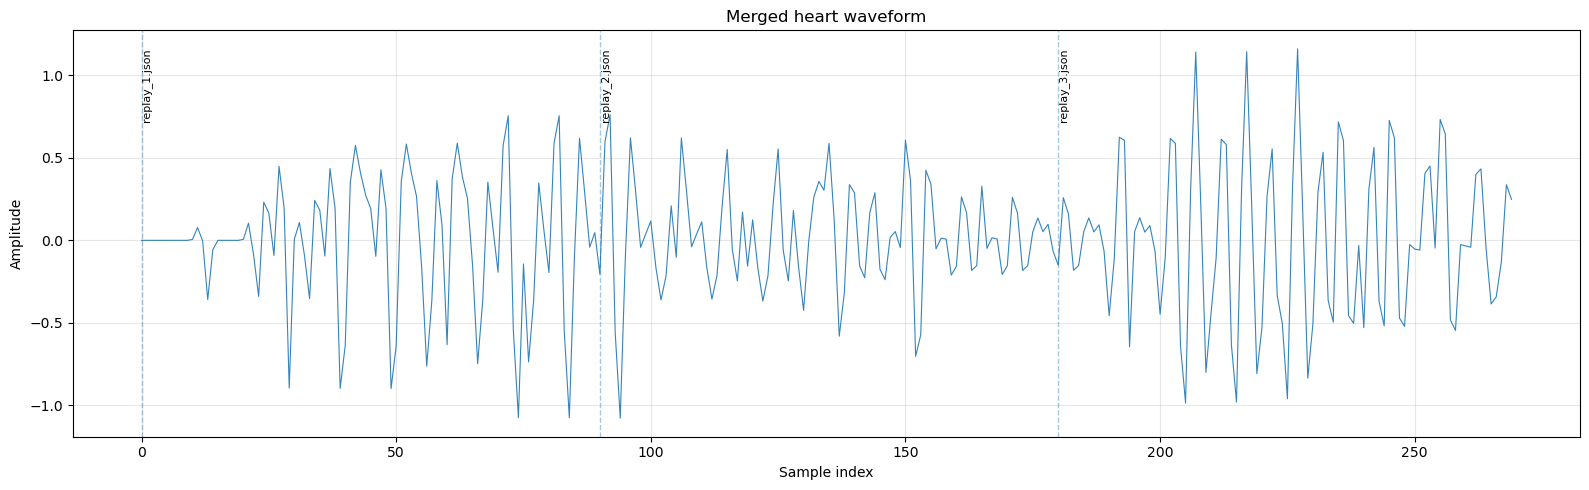

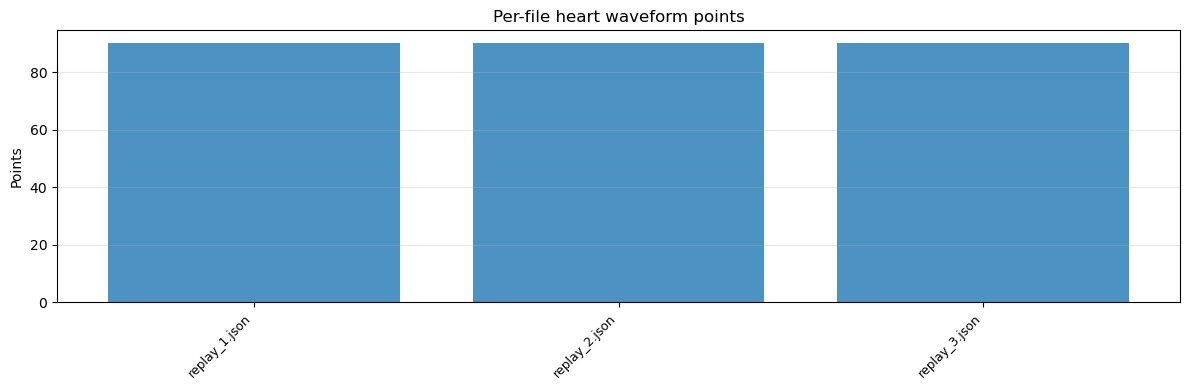

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Unified mmWave vitals merger using load_frames(paths).
- Keeps the file-reading style from the second snippet (load_frames).
- Extracts per-frame vitals.heartWaveform and merges across files.
- Produces stats and a plot.

Usage:
    python mmwave_heart_merge.py /path/to/folder [-o outputs]

In notebooks:
    from mmwave_heart_merge import process_vitals_folder
    summary = process_vitals_folder("data", outdir="outputs")
"""
import os
import re
import glob
import json
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# -----------------------------
# I/O helpers
# -----------------------------

def natural_sort_key(filename):
    """自然排序：replay_1, replay_2, ..., replay_10"""
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else 0

def find_replay_jsons(folder):
    """Find replay_*.json under folder, natural-sorted."""
    pattern = os.path.join(folder, "replay_*.json")
    files = glob.glob(pattern)
    files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
    return files

# -----------------------------
# Core loader following the "load_frames(paths)" pattern
# -----------------------------

def load_frames(paths):
    """
    Load and parse JSON frame data from multiple files.
    Returns a pandas DataFrame sorted by timestamp.
    Columns:
        source, frame, timestamp_ms,
        heartWaveform, heartRate, breathRate, rangeBin, breathDeviation,
        numTracks, numPoints
    """
    rows = []
    for p in paths:
        if not os.path.exists(p):
            print(f"[warn] file not found: {p}")
            continue
        with open(p, "r", encoding="utf-8") as f:
            root = json.load(f)

        for entry in root.get("data", []):
            fd = entry.get("frameData", {}) or {}
            ts = entry.get("timestamp", None)  # ms
            frame_num = fd.get("frameNum", None)

            vit = fd.get("vitals", None) or {}
            hw = vit.get("heartWaveform", None)
            hr = vit.get("heartRate", None)
            br = vit.get("breathRate", None)
            rb = vit.get("rangeBin", None)
            bd = vit.get("breathDeviation", None)

            rows.append({
                "source": os.path.basename(p),
                "frame": frame_num,
                "timestamp_ms": ts,
                "numTracks": fd.get("numDetectedTracks", None),
                "numPoints": fd.get("numDetectedPoints", None),
                "heartWaveform": hw if isinstance(hw, list) else None,
                "heartRate": hr,
                "breathRate": br,
                "rangeBin": rb,
                "breathDeviation": bd,
            })

    df = pd.DataFrame(rows).dropna(subset=["timestamp_ms"])
    df = df.sort_values(["timestamp_ms", "source", "frame"], kind="mergesort").reset_index(drop=True)
    return df

# -----------------------------
# Processing and plotting
# -----------------------------

def merge_heart_waveforms(df):
    """
    Merge all available heartWaveform arrays in time order.
    Returns:
        wave (np.ndarray), segments (list of dict per source file)
    """
    all_wave = []
    segments = []  # per-file segment boundaries for plotting and stats

    # record cumulative offset when each file starts
    cur_offset = 0
    for src, sub in df.groupby("source", sort=False):
        file_points = 0
        frames_info = []
        for _, row in sub.iterrows():
            wf = row.get("heartWaveform", None)
            if isinstance(wf, list) and len(wf) > 0:
                start = cur_offset + file_points
                all_wave.extend(wf)
                end = cur_offset + file_points + len(wf)
                frames_info.append({
                    "frameNum": int(row["frame"]) if pd.notna(row["frame"]) else None,
                    "timestamp": float(row["timestamp_ms"]),
                    "heartRate": float(row["heartRate"]) if pd.notna(row["heartRate"]) else None,
                    "waveformLength": int(len(wf)),
                    "startIndex": int(start),
                    "endIndex": int(end)
                })
                file_points += len(wf)

        segments.append({
            "filename": src,
            "totalPoints": int(file_points),
            "frameCount": int(len(frames_info)),
            "startIndex": int(cur_offset),
            "endIndex": int(cur_offset + file_points),
            "frame_info": frames_info
        })
        cur_offset += file_points

    return np.asarray(all_wave, dtype=float), segments

def print_statistics(wave, segments, df_meta=None):
    """Print summary statistics and per-file info."""
    if wave.size == 0:
        print("[warn] No heartWaveform data found.")
        return

    print("\n" + "="*60)
    print("統計資訊")
    print("="*60)
    print(f"總資料點數: {len(wave)}")
    print(f"最大振幅: {np.max(wave):.4f}")
    print(f"最小振幅: {np.min(wave):.4f}")
    print(f"平均振幅: {np.mean(wave):.4f}")
    print(f"標準差: {np.std(wave):.4f}\n")

    print("檔案詳情:")
    print("-"*60)
    for seg in segments:
        print(f"\n檔案: {seg['filename']}")
        print(f"  資料點: {seg['totalPoints']}")
        print(f"  Frame數: {seg['frameCount']}")
        print(f"  索引範圍: [{seg['startIndex']}, {seg['endIndex']})")

        hrs = [fi["heartRate"] for fi in seg["frame_info"] if fi["heartRate"] is not None and fi["heartRate"] > 0]
        if hrs:
            print(f"  平均心率: {np.mean(hrs):.2f} bpm")
            print(f"  心率範圍: {np.min(hrs):.2f} - {np.max(hrs):.2f} bpm")

def plot_heart_waveform(wave, segments, save_path=None):
    """
    Plot the merged heart waveform and per-file counts.
    Conforms to the one-chart-per-figure guidance when called separately.
    """
    if wave.size == 0:
        return

    # Primary waveform
    plt.figure(figsize=(16, 5))
    t = np.arange(len(wave))
    plt.plot(t, wave, linewidth=0.8, alpha=0.9)
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.title("Merged heart waveform")
    plt.grid(True, alpha=0.3)

    # Mark file boundaries
    ymax = np.max(wave) if wave.size else 1.0
    for seg in segments:
        x = seg["startIndex"]
        plt.axvline(x=x, linestyle="--", alpha=0.4, linewidth=1.0)
        plt.text(x, ymax, seg["filename"], rotation=90, va="top", fontsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()

    # Per-file counts chart
    plt.figure(figsize=(12, 4))
    counts = [s["totalPoints"] for s in segments]
    labels = [s["filename"] for s in segments]
    x = np.arange(len(counts))
    plt.bar(x, counts, alpha=0.8)
    plt.xticks(x, labels, rotation=45, ha="right", fontsize=9)
    plt.ylabel("Points")
    plt.title("Per-file heart waveform points")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()
    if save_path:
        base, ext = os.path.splitext(save_path)
        plt.savefig(base + "_counts" + ext, dpi=200, bbox_inches="tight")
    plt.show()

# -----------------------------
# High-level API
# -----------------------------

def process_vitals_folder(folder_path, outdir="outputs", fs_hint=10.0):
    """
    Find and load replay_*.json, merge vitals.heartWaveform, print stats, and plot.
    Returns:
        {
            "waveforms": np.ndarray,
            "segments": list[dict],
            "csv": path,
            "plot": path
        }
    """
    files = find_replay_jsons(folder_path)
    if not files:
        print(f"[error] No replay_*.json files found in: {folder_path}")
        return None

    print(f"Found {len(files)} files:")
    for f in files:
        print("  -", os.path.basename(f))
    print()

    df = load_frames(files)
    if df.empty:
        print("[error] No frames with timestamps found.")
        return None

    wave, segments = merge_heart_waveforms(df)
    if wave.size == 0:
        print("[error] No heartWaveform data found in frames.")
        return None

    # Outputs
    os.makedirs(outdir, exist_ok=True)

    # time axis assuming approx constant sampling fs_hint
    fs = float(fs_hint)
    t_uni = np.arange(len(wave), dtype=float) / fs if len(wave) > 0 else np.array([], dtype=float)

    # CSV with t_sec and heartbeat
    csv_path = os.path.join(outdir, "heart_rate_series.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "heartbeat": wave.astype(float)
    })
    result_df.to_csv(csv_path, index=False)

    # Plot and save as heartbeat.png
    heart_png = os.path.join(outdir, "heartbeat.png")
    print_statistics(wave, segments, df_meta=df)
    plot_heart_waveform(wave, segments, save_path=heart_png)

    # Summary with the exact required structure
    summary = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]) if len(t_uni) > 1 else 0.0,
        "fs_Hz": float(fs),
        "est_hr_bpm": None,
        "csv": csv_path,
        "heartbeat_png": heart_png,
        "dataframe": result_df,
    }
    return summary

# -----------------------------
# CLI
# -----------------------------

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("folder", help="Folder containing replay_*.json")
    ap.add_argument("-o", "--outdir", default="outputs", help="Output directory")
    args = ap.parse_args()

    summary = process_vitals_folder(args.folder, outdir=args.outdir)
    if summary is None:
        raise SystemExit(1)


if __name__ == "__main__":
    summary = process_vitals_folder(r"E:\重要文件\毫米波\radar-heartbeat-detection\實驗區\data\sample_1", outdir="outputs")


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
mmWave heart rate extraction from JSON logs (Notebook Version).

Usage in Jupyter Notebook:
  process_vitals_folder("path/to/json/folder", outdir="outputs")
"""
import os
import json
import glob
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display, HTML


def load_frames(paths):
    """Load and parse JSON frame data from multiple files."""
    rows = []
    for p in paths:
        if not os.path.exists(p):
            print(f"[warn] file not found: {p}")
            continue
        with open(p, "r", encoding="utf-8") as f:
            root = json.load(f)

        for entry in root.get("data", []):
            fd = entry.get("frameData", {})
            ts = entry.get("timestamp", None)  # ms
            frame_num = fd.get("frameNum", None)

            track = None
            td = fd.get("trackData", None)
            # Accept common shapes: list-of-lists or list-of-dicts
            if isinstance(td, list) and len(td) > 0:
                if isinstance(td[0], list):
                    track = td[0]
                elif isinstance(td[0], dict):
                    # try common keys
                    cand = td[0]
                    if all(k in cand for k in ("x", "y", "z")):
                        track = [cand["x"], cand["y"], cand["z"]]
                    elif "pos" in cand and isinstance(cand["pos"], list) and len(cand["pos"]) >= 3:
                        track = cand["pos"][:3]

            rows.append({
                "source": os.path.basename(p),
                "frame": frame_num,
                "timestamp_ms": ts,
                "track": track,
                "numTracks": fd.get("numDetectedTracks", None),
                "numPoints": fd.get("numDetectedPoints", None)
            })
    df = pd.DataFrame(rows).dropna(subset=["timestamp_ms"])
    df = df.sort_values("timestamp_ms").reset_index(drop=True)
    return df


def extract_xyz(track):
    """Extract x, y, z coordinates from track data."""
    if track is None:
        return (np.nan, np.nan, np.nan)
    if isinstance(track, (list, tuple)) and len(track) >= 3:
        return (float(track[0]), float(track[1]), float(track[2]))
    return (np.nan, np.nan, np.nan)


def bandpass(sig, fs, f1, f2, order=4):
    """Apply Butterworth bandpass filter."""
    ny = 0.5 * fs
    low = max(1e-4, f1 / ny)
    high = min(0.99, f2 / ny)
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, sig)


def estimate_rate(sig, fs, min_bpm, max_bpm):
    """Estimate heart rate from signal."""
    if len(sig) < 10:
        return np.nan
    min_dist = max(1, int(fs * 60.0 / max_bpm))
    prom = np.std(sig) * 0.2
    peaks, _ = signal.find_peaks(sig, distance=min_dist, prominence=prom)
    if len(peaks) < 2:
        return np.nan
    intervals = np.diff(peaks) / fs
    med = np.median(intervals)
    if not np.isfinite(med) or med <= 0:
        return np.nan
    return 60.0 / med


def resample_uniform(t_sec, y, fs_hint=None):
    """Resample signal to uniform time intervals."""
    dt = np.median(np.diff(t_sec))
    if not np.isfinite(dt) or dt <= 0:
        fs = fs_hint if fs_hint else 20.0
    else:
        fs = 1.0 / dt
    fs = float(np.clip(fs, 5.0, 200.0))
    t_uniform = np.arange(t_sec[0], t_sec[-1], 1.0 / fs)
    y_uniform = np.interp(t_uniform, t_sec, y)
    return fs, t_uniform, y_uniform


def plot_series_inline(t, y, title, ylabel):
    """Plot time series inline in notebook."""
    plt.figure(figsize=(12, 4))
    plt.plot(t, y, linewidth=1)
    plt.xlabel("Time (s)", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def process_vitals_folder(folder_path, outdir="outputs", fs_hint=20.0):
    """
    Process all JSON files in a folder for heart rate extraction.
    
    Parameters:
    -----------
    folder_path : str
        Path to folder containing JSON files
    outdir : str
        Output directory for CSV and PNG files
    fs_hint : float
        Fallback sampling rate if timestamps are irregular
    """
    # Find all JSON files in folder
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    
    if not json_files:
        print(f"[error] No JSON files found in {folder_path}")
        return None
    
    print(f"Found {len(json_files)} JSON files:")
    for f in json_files:
        print(f"  - {os.path.basename(f)}")
    print()
    
    # Load frames
    df = load_frames(json_files)
    if df.empty:
        print("[error] No frames with timestamps found.")
        return None

    # Extract xyz and range
    xyz = np.array([extract_xyz(tr) for tr in df["track"]], dtype=float)
    df["x"], df["y"], df["z"] = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    df["range_m"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
    df2 = df.dropna(subset=["range_m", "timestamp_ms"])
    
    if df2.empty:
        print("[error] No valid trackData with xyz found.")
        return None

    print(f"Loaded {len(df2)} valid frames")
    print(f"Time range: {df2['timestamp_ms'].iloc[0]:.0f} - {df2['timestamp_ms'].iloc[-1]:.0f} ms")
    print()

    # Time axis in seconds
    t = (df2["timestamp_ms"].to_numpy() - df2["timestamp_ms"].iloc[0]) / 1000.0
    r = df2["range_m"].to_numpy()

    # Uniform resample for stable filtering
    fs, t_uni, r_uni = resample_uniform(t, r, fs_hint=fs_hint)
    print(f"Resampled to {fs:.1f} Hz ({len(t_uni)} samples)")
    
    # Detrend
    r_detr = signal.detrend(r_uni, type="linear")

    # Heart rate bandpass filter: 0.8-3.0 Hz (48-180 bpm)
    heart = bandpass(r_detr, fs, 0.8, 3.0)

    # Heart rate estimate
    hr_bpm = estimate_rate(heart, fs, 40, 180)

    # Display results
    print("\n" + "="*60)
    print("HEART RATE ESTIMATION RESULTS")
    print("="*60)
    print(f"Duration: {t_uni[-1] - t_uni[0]:.1f} seconds")
    print(f"Sampling rate: {fs:.1f} Hz")
    
    if np.isfinite(hr_bpm):
        print(f"Estimated Heart Rate: {hr_bpm:.1f} beats/min")
    else:
        print("Estimated Heart Rate: Unable to estimate")
    print("="*60 + "\n")

    # Save CSV
    os.makedirs(outdir, exist_ok=True)
    csv_path = os.path.join(outdir, "heart_rate_series.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "range_detrended": r_detr,
        "heartbeat": heart
    })
    result_df.to_csv(csv_path, index=False)
    print(f"Saved time series to: {csv_path}\n")

    # Plot heartbeat
    heart_title = f"Heartbeat-band displacement (est HR ≈ {hr_bpm:.1f} bpm)" if np.isfinite(hr_bpm) else "Heartbeat-band displacement"
    plot_series_inline(t_uni, heart, heart_title, "Heartbeat (a.u.)")

    # Save PNG file
    plt.figure(figsize=(12, 4))
    plt.plot(t_uni, heart, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Heartbeat (a.u.)")
    plt.title(heart_title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    heart_png = os.path.join(outdir, "heartbeat.png")
    plt.savefig(heart_png, dpi=200)
    plt.close()

    print(f"Saved plot to: {heart_png}\n")

    # Return summary
    summary = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]),
        "fs_Hz": float(fs),
        "est_hr_bpm": float(hr_bpm) if np.isfinite(hr_bpm) else None,
        "csv": csv_path,
        "heartbeat_png": heart_png,
        "dataframe": result_df
    }
        # 供三聯圖使用：原始時間與量測
    t_raw = (df2["timestamp_ms"].to_numpy() - df2["timestamp_ms"].iloc[0]) / 1000.0
    r_raw = df2["range_m"].to_numpy()

    # 畫出波形
    plot_waveforms_triple(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir)
    plot_waveforms_overlay(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir, normalize=True)

    return summary

def plot_waveforms_triple(t_raw, r_raw, t_uni, r_detr, heart, outdir="outputs"):
    import os
    os.makedirs(outdir, exist_ok=True)

    # 各自單圖
    for name, tx, y in [
        ("raw_range.png", t_raw, r_raw),
        ("detrended.png", t_uni, r_detr),
        ("heartbeat_band.png", t_uni, heart),
    ]:
        plt.figure(figsize=(12,4))
        plt.plot(tx, y, linewidth=1)
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
        plt.title(name.replace("_"," ").replace(".png",""))
        plt.tight_layout()
        #plt.savefig(os.path.join(outdir, name), dpi=200)
        plt.show()

def plot_waveforms_overlay(t_raw, r_raw, t_uni, r_detr, heart, outdir="outputs", normalize=True):
    import os
    os.makedirs(outdir, exist_ok=True)

    # 將 raw 內插到 t_uni 以便對齊
    r_raw_i = np.interp(t_uni, t_raw, r_raw)

    def _znorm(x):
        m, s = np.mean(x), np.std(x)
        return (x - m) / (s + 1e-12)

    if normalize:
        y1 = _znorm(r_raw_i)
        y2 = _znorm(r_detr)
        y3 = _znorm(heart)
        y_label = "Normalized amplitude (z-score)"
    else:
        y1, y2, y3 = r_raw_i, r_detr, heart
        y_label = "Amplitude"

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(t_uni, y1, linewidth=1, label="Raw range (interp→t_uni)")
    plt.plot(t_uni, y2, linewidth=1, label="Detrended range")
    plt.plot(t_uni, y3, linewidth=1.2, label="Heartbeat-band (0.8–3.0 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel(y_label)
    plt.title("Raw / Detrended / Heartbeat-band — single figure")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "waveforms_overlay.png"), dpi=200)
    plt.show()

# Example usage:
#summary = process_vitals_folder(r"E:\重要文件\毫米波\radar-heartbeat-detection\實驗區\data\sample_1", outdir="outputs")
# 
# Or if you want to access the data:
# df = summary['dataframe']
# print(df.head())
# print(f"Heart Rate: {summary['est_hr_bpm']} bpm")

Spectrum Analysis
Signal length: 270 samples
Duration: 26.9 sec
Sampling rate: 10.0 Hz

1) FFT...
   Dominant frequency (within 40-180 bpm): 124.4 bpm (2.074 Hz)



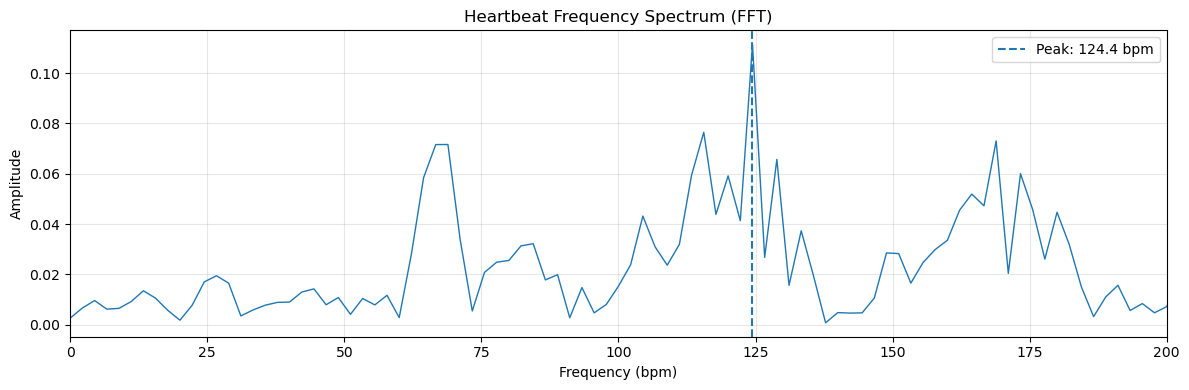

2) Spectrogram...
   Time res: 4.00 s  |  Freq res: 7.50 bpm



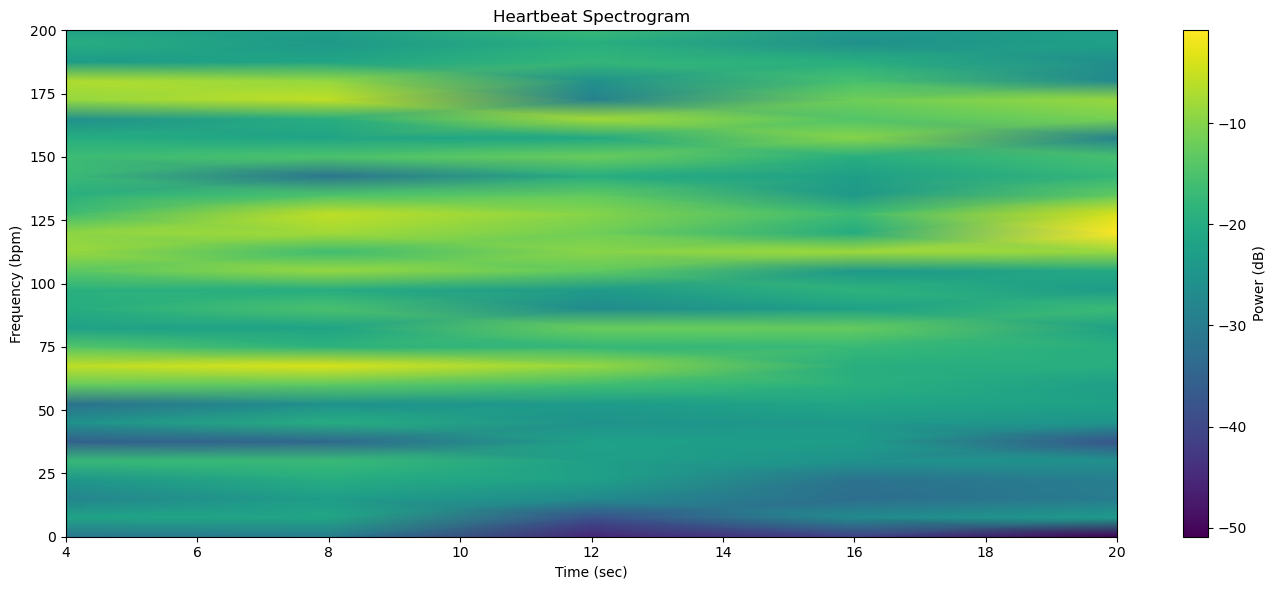

3) Band energy...
   Very Low (<40 bpm)  :                                                      2.0%
   Low (40-60 bpm)     :                                                      1.0%
   Normal (60-100 bpm) : ███████████                                         22.4%
   High (100-120 bpm)  : ████████                                            17.7%
   Very High (>120 bpm): ████████████████████████████                        56.9%



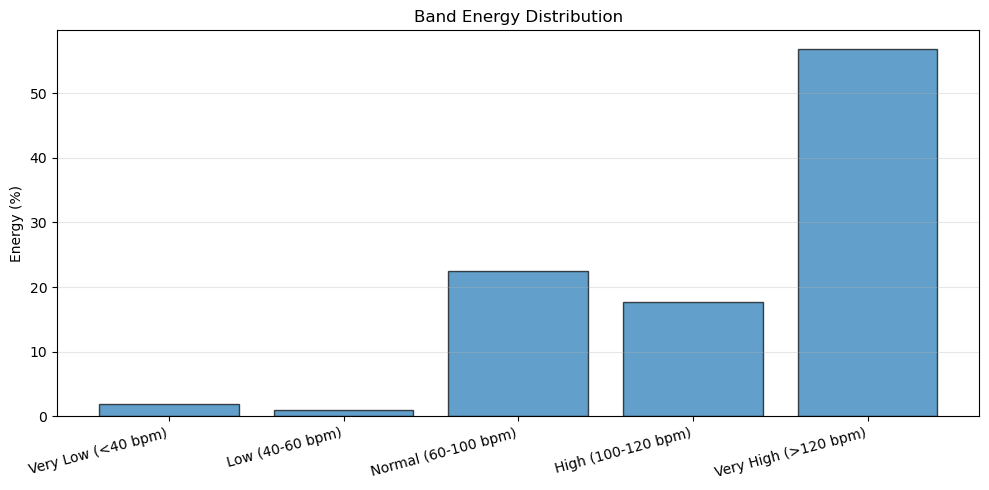

In [5]:
"""
Spectrum Analysis Block - Run in another Notebook cell

Usage:
1. First run the main processing to get summary
2. Then run this block to perform spectrum analysis

Example:
    summary = process_vitals_folder("data/json_logs")
    # Then run the analysis below
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def analyze_spectrum(summary, save_plots=True, outdir=None,
                     bpm_min=40, bpm_max=180, welch_win_sec=8.0):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import signal

    # ---- get data
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    x = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])

    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')

    n = len(x)
    if n < 16:
        raise ValueError("signal too short")

    # ---- preproc: detrend + window
    x = signal.detrend(x, type="linear")
    w = np.hanning(n)
    xw = x * w
    # 能量保真正規化
    xw = xw / (w.sum() + 1e-12)

    print("="*60)
    print("Spectrum Analysis")
    print("="*60)
    print(f"Signal length: {n} samples")
    print(f"Duration: {t_sec[-1] - t_sec[0]:.1f} sec")
    print(f"Sampling rate: {fs:.1f} Hz\n")

    # ==================== 1) FFT spectrum ====================
    print("1) FFT...")
    freq = np.fft.rfftfreq(n, 1.0/fs)
    fft_vals = np.abs(np.fft.rfft(xw))
    freq_bpm = freq * 60.0

    # 只在生理合理區間找峰
    mask = (freq_bpm >= bpm_min) & (freq_bpm <= bpm_max)
    if not np.any(mask):
        raise ValueError("no bins in bpm range")
    idx_local = np.argmax(fft_vals[mask])
    idx_max = np.flatnonzero(mask)[idx_local]

    dominant_freq_hz = float(freq[idx_max])
    dominant_freq_bpm = float(freq_bpm[idx_max])

    est_hr_from_summary = summary.get('est_hr_bpm', None)
    diff_bpm = (abs(dominant_freq_bpm - float(est_hr_from_summary))
                if est_hr_from_summary is not None and np.isfinite(est_hr_from_summary)
                else np.nan)

    print(f"   Dominant frequency (within {bpm_min}-{bpm_max} bpm): "
          f"{dominant_freq_bpm:.1f} bpm ({dominant_freq_hz:.3f} Hz)")
    if np.isfinite(diff_bpm):
        print(f"   Difference vs. peak detection: {diff_bpm:.1f} bpm")
    print()

    # plot FFT
    plt.figure(figsize=(12, 4))
    plt.plot(freq_bpm, fft_vals, linewidth=1)
    plt.axvline(dominant_freq_bpm, linestyle='--',
                label=f'Peak: {dominant_freq_bpm:.1f} bpm')
    plt.xlabel("Frequency (bpm)"); plt.ylabel("Amplitude")
    plt.title("Heartbeat Frequency Spectrum (FFT)")
    plt.xlim([0, 200]); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_plots:
        spectrum_path = f"{outdir}/spectrum.png"
        plt.savefig(spectrum_path, dpi=200)
        print(f"Saved spectrum plot: {spectrum_path}")
    plt.show()

    # ==================== 2) Spectrogram (Welch參數一致化) ====================
    print("2) Spectrogram...")
    nperseg = int(min(max(welch_win_sec*fs, 64), n//2))
    f, t_spec, Sxx = signal.spectrogram(x, fs, nperseg=nperseg, noverlap=int(0.5*nperseg))
    f_bpm = f * 60.0
    Sxx_db = 10*np.log10(Sxx + 1e-12)

    print(f"   Time res: {t_spec[1]-t_spec[0]:.2f} s  |  Freq res: {(f_bpm[1]-f_bpm[0]):.2f} bpm\n")

    plt.figure(figsize=(14, 6))
    im = plt.pcolormesh(t_spec, f_bpm, Sxx_db, shading='gouraud')
    cbar = plt.colorbar(im, label='Power (dB)')
    plt.ylabel('Frequency (bpm)'); plt.xlabel('Time (sec)')
    plt.title('Heartbeat Spectrogram'); plt.ylim([0, 200])
    if est_hr_from_summary is not None and np.isfinite(est_hr_from_summary):
        plt.axhline(est_hr_from_summary, linestyle='--', linewidth=2, alpha=0.7,
                    label=f"Estimated HR: {est_hr_from_summary:.1f} bpm")
        plt.legend(loc='upper right')
    plt.tight_layout()
    if save_plots:
        spectrogram_path = f"{outdir}/spectrogram.png"
        plt.savefig(spectrogram_path, dpi=200)
        print(f"Saved spectrogram plot: {spectrogram_path}")
    plt.show()

    # ==================== 3) Band energy ====================
    print("3) Band energy...")
    bands = {
        "Very Low (<40 bpm)": (0, 40),
        "Low (40-60 bpm)": (40, 60),
        "Normal (60-100 bpm)": (60, 100),
        "High (100-120 bpm)": (100, 120),
        "Very High (>120 bpm)": (120, 200)
    }
    band_energy = {}
    # 用未加遮罩的全頻 fft_vals，但請注意 peak 搜索已限 40–180
    for name, (lo, hi) in bands.items():
        m = (freq_bpm >= lo) & (freq_bpm < hi)
        band_energy[name] = float(np.sum(fft_vals[m]**2))
    total = sum(band_energy.values()) + 1e-12
    band_percentage = {k: 100.0*v/total for k, v in band_energy.items()}

    for name, pct in band_percentage.items():
        bar = "█" * int(pct/2)
        print(f"   {name:20s}: {bar:50s} {pct:5.1f}%")
    print()

    plt.figure(figsize=(10, 5))
    plt.bar(list(band_percentage.keys()), list(band_percentage.values()), alpha=0.7, edgecolor='black')
    plt.ylabel('Energy (%)'); plt.title('Band Energy Distribution')
    plt.xticks(rotation=15, ha='right'); plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    if save_plots:
        energy_path = f"{outdir}/energy_distribution.png"
        plt.savefig(energy_path, dpi=200)
        print(f"Saved energy distribution plot: {energy_path}")
    plt.show()

    results = {
        "dominant_freq_bpm": dominant_freq_bpm,
        "dominant_freq_hz": dominant_freq_hz,
        "freq_bpm": freq_bpm,
        "fft_amplitude": fft_vals,
        "spectrogram_time": t_spec,
        "spectrogram_freq": f_bpm,
        "spectrogram_power": Sxx_db,
        "band_energy_percentage": band_percentage
    }
    print("="*60 + "\n")
    return results

# ==================== 使用範例 ====================
# 在主程式執行後，使用此函數進行頻譜分析:
#
# summary = process_vitals_folder("data/json_logs")
spectrum_results = analyze_spectrum(summary, save_plots=False)
#
# # 存取頻譜資料
# print(f"主要頻率: {spectrum_results['dominant_freq_bpm']:.1f} bpm")
# print(f"正常心率能量佔比: {spectrum_results['band_energy_percentage']['正常 (60-100 bpm)']:.1f}%")

Cepstrum Analysis
Global HR estimate from cepstrum: 60.0 bpm
Track HR: mean=53.9 bpm, std=11.7 bpm
Quefrency search window: [0.300, 1.500] s  (HR 40-200 bpm)
Liftering: q < 0.100 s set to 0


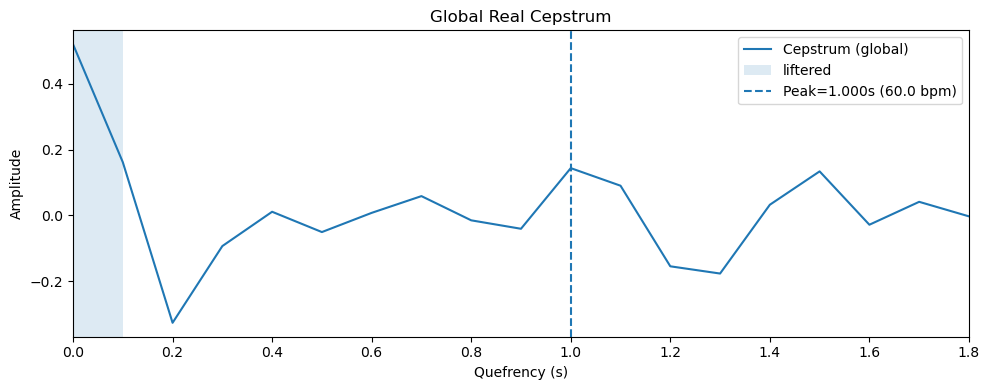

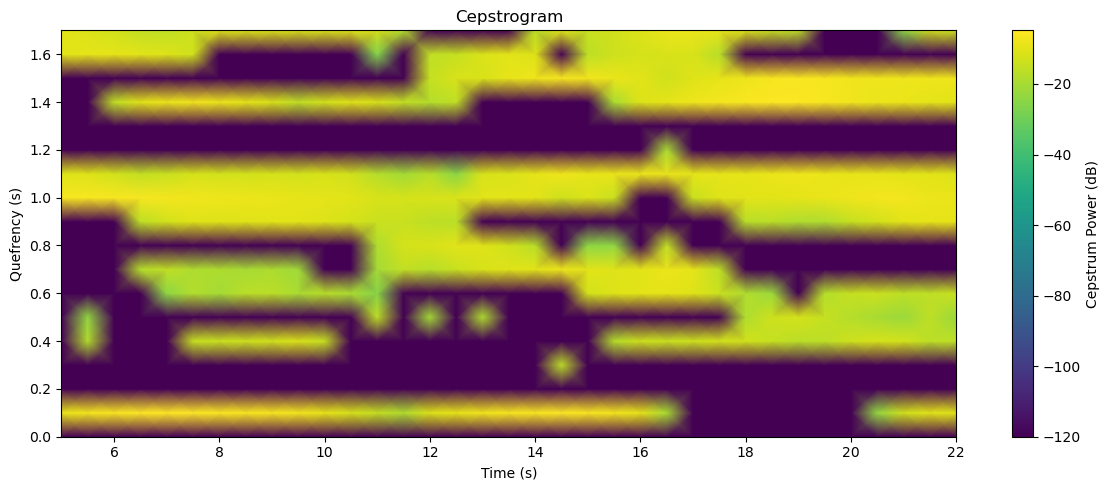

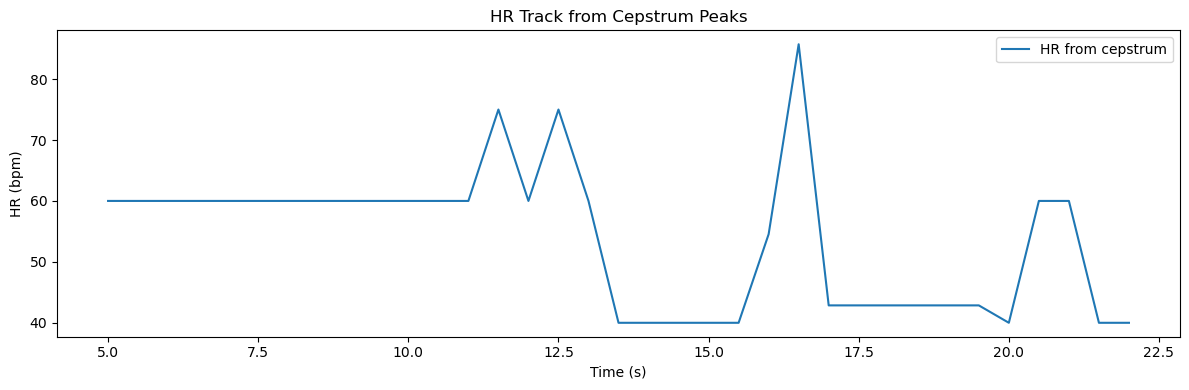

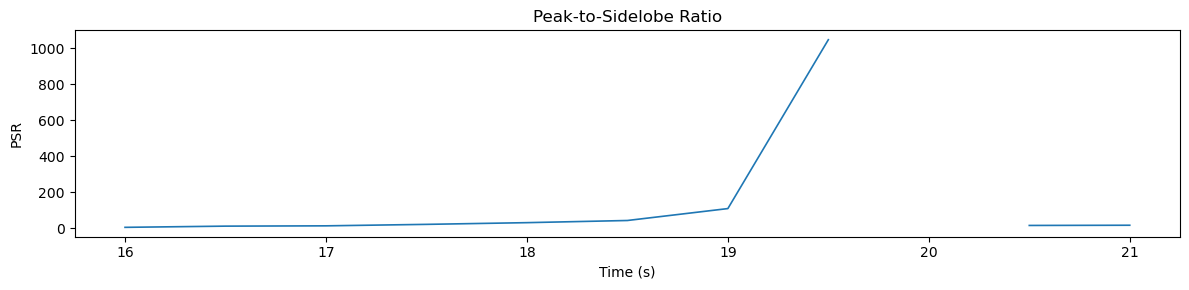

Global HR (cepstrum): 60.0


In [6]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def analyze_cepstrum(summary,
                     save_plots=True,
                     outdir=None,
                     hr_range_bpm=(40, 200),
                     lifter_q_sec=0.10,
                     win_sec=10.0,
                     hop_sec=0.5,
                     eps=1e-12):
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    x = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])
    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')

    N = len(x)
    hr_lo, hr_hi = hr_range_bpm
    q_lo = 60.0 / hr_hi
    q_hi = 60.0 / hr_lo

    # ---------- 全段倒頻譜（使用 N 長度窗，nfft 取 >= N 的 2 次方） ----------
    nfft_global = int(2 ** np.ceil(np.log2(max(16, N))))
    w_glob = signal.windows.hann(N, sym=False)
    Xg = np.fft.rfft(x * w_glob, n=nfft_global)
    Lg = np.log(np.maximum(np.abs(Xg), eps))
    c_global = np.real(np.fft.irfft(Lg, n=nfft_global))
    q_axis_g = np.arange(nfft_global) / fs

    # liftering 與 HR 搜尋窗
    c_glift = c_global.copy()
    c_glift[q_axis_g < lifter_q_sec] = 0.0
    mask_hr_q_g = (q_axis_g >= max(q_lo, lifter_q_sec)) & (q_axis_g <= q_hi)
    q_star_global = q_axis_g[mask_hr_q_g][np.argmax(c_glift[mask_hr_q_g])]
    hr_global = 60.0 / q_star_global

    # ---------- 滑動窗參數（不超過訊號長度） ----------
    win_len = int(round(win_sec * fs))
    hop_len = int(round(hop_sec * fs))
    if win_len > N:
        win_len = N
    if hop_len < 1:
        hop_len = 1
    if win_len < 4:
        raise ValueError("win_sec too short given fs and signal length.")

    nfft_win = int(2 ** np.ceil(np.log2(max(16, win_len))))
    q_axis_w = np.arange(nfft_win) / fs
    mask_hr_q_w = (q_axis_w >= max(q_lo, lifter_q_sec)) & (q_axis_w <= q_hi)

    # ---------- 逐窗 cepstrogram 與 HR 軌跡 ----------
    w = signal.windows.hann(win_len, sym=False)
    centers, q_peaks, hr_track, conf_psr, frames = [], [], [], [], []

    for start in range(0, max(1, N - win_len + 1), hop_len):
        seg = x[start:start + win_len]
        if len(seg) < win_len:
            break
        Xw = np.fft.rfft(seg * w, n=nfft_win)
        Lw = np.log(np.maximum(np.abs(Xw), eps))
        c = np.real(np.fft.irfft(Lw, n=nfft_win))

        # liftering
        c[q_axis_w < lifter_q_sec] = 0.0

        # HR 對應 quefrency 主峰
        c_hr = np.where(mask_hr_q_w, c, 0.0)
        pk_idx = int(np.argmax(c_hr))
        q_pk = q_axis_w[pk_idx]
        hr = 60.0 / q_pk

        # PSR（主峰對旁瓣比）
        sl_mask = mask_hr_q_w.copy()
        win_ex = 2
        sl_mask[max(0, pk_idx - win_ex):min(len(sl_mask), pk_idx + win_ex + 1)] = False
        sidelobe = np.mean(c[sl_mask]) if np.any(sl_mask) else 0.0
        psr = (c[pk_idx] / (sidelobe + 1e-9)) if sidelobe > 0 else np.inf

        centers.append(t_sec[min(start + win_len // 2, N - 1)])
        q_peaks.append(q_pk)
        hr_track.append(hr)
        conf_psr.append(psr)
        frames.append(c)

    centers = np.asarray(centers)
    q_peaks = np.asarray(q_peaks)
    hr_track = np.asarray(hr_track)
    conf_psr = np.asarray(conf_psr)
    cepstrogram = np.stack(frames, axis=1) if len(frames) else np.zeros((nfft_win, 0))

    # ---------- 視覺化 ----------
    print("=" * 60)
    print("Cepstrum Analysis")
    print("=" * 60)
    print(f"Global HR estimate from cepstrum: {hr_global:.1f} bpm")
    if len(hr_track):
        print(f"Track HR: mean={np.nanmean(hr_track):.1f} bpm, std={np.nanstd(hr_track):.1f} bpm")
    print(f"Quefrency search window: [{q_lo:.3f}, {q_hi:.3f}] s  (HR {hr_lo}-{hr_hi} bpm)")
    print(f"Liftering: q < {lifter_q_sec:.3f} s set to 0")

    # 全段
    plt.figure(figsize=(10, 4))
    plt.plot(q_axis_g, c_global, label="Cepstrum (global)")
    plt.axvspan(0, lifter_q_sec, alpha=0.15, label="liftered")
    plt.axvline(q_star_global, linestyle='--', label=f'Peak={q_star_global:.3f}s ({hr_global:.1f} bpm)')
    plt.xlim(0, min(2.0, q_hi * 1.2))
    plt.xlabel("Quefrency (s)"); plt.ylabel("Amplitude"); plt.title("Global Real Cepstrum")
    plt.legend(); plt.tight_layout()
    if save_plots: plt.savefig(f"{outdir}/cepstrum_global.png", dpi=200)
    plt.show()

    # cepstrogram
    if cepstrogram.shape[1] > 0:
        q_max_plot = min(2.0, q_hi * 1.2)
        q_mask_plot = q_axis_w <= q_max_plot
        C_db = 10 * np.log10(np.maximum(cepstrogram[q_mask_plot, :], eps))
        plt.figure(figsize=(12, 5))
        im = plt.pcolormesh(centers, q_axis_w[q_mask_plot], C_db, shading='gouraud')
        plt.colorbar(im, label='Cepstrum Power (dB)')
        plt.xlabel("Time (s)"); plt.ylabel("Quefrency (s)"); plt.title("Cepstrogram")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrogram.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(centers, hr_track, linewidth=1.5, label="HR from cepstrum")
        if summary.get('est_hr_bpm') and np.isfinite(summary['est_hr_bpm']):
            plt.axhline(summary['est_hr_bpm'], linestyle='--',
                        label=f"Est. HR (summary) {summary['est_hr_bpm']:.1f} bpm")
        plt.xlabel("Time (s)"); plt.ylabel("HR (bpm)"); plt.title("HR Track from Cepstrum Peaks")
        plt.legend(); plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/hr_track_cepstrum.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 3))
        plt.plot(centers, conf_psr, linewidth=1.2)
        plt.xlabel("Time (s)"); plt.ylabel("PSR"); plt.title("Peak-to-Sidelobe Ratio")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrum_confidence_psr.png", dpi=200)
        plt.show()

    return {
        "q_axis_global_sec": q_axis_g,
        "cepstrum_global": c_global,
        "q_star_global_sec": float(q_star_global),
        "hr_global_bpm": float(hr_global),
        "q_axis_win_sec": q_axis_w,
        "centers_sec": centers,
        "cepstrogram": cepstrogram,
        "q_peak_track_sec": q_peaks,
        "hr_track_bpm": hr_track,
        "confidence_psr": conf_psr,
        "params": {
            "fs_Hz": fs, "win_sec": win_sec, "hop_sec": hop_sec,
            "hr_range_bpm": hr_range_bpm, "lifter_q_sec": lifter_q_sec,
            "nfft_global": nfft_global, "nfft_win": nfft_win
        }
    }

# ===== 使用示例 =====
#spectrum_results = analyze_spectrum(summary, save_plots=True)
cep_results = analyze_cepstrum(summary, save_plots=False)
print("Global HR (cepstrum):", cep_results["hr_global_bpm"])


In [7]:

import os
import json
import glob
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display, HTML


def load_frames(paths):
    """Load and parse JSON frame data from multiple files."""
    rows = []
    for p in paths:
        if not os.path.exists(p):
            print(f"[warn] file not found: {p}")
            continue
        with open(p, "r", encoding="utf-8") as f:
            root = json.load(f)

        for entry in root.get("data", []):
            fd = entry.get("frameData", {})
            ts = entry.get("timestamp", None)  # ms
            frame_num = fd.get("frameNum", None)

            track = None
            td = fd.get("trackData", None)
            # Accept common shapes: list-of-lists or list-of-dicts
            if isinstance(td, list) and len(td) > 0:
                if isinstance(td[0], list):
                    track = td[0]
                elif isinstance(td[0], dict):
                    # try common keys
                    cand = td[0]
                    if all(k in cand for k in ("x", "y", "z")):
                        track = [cand["x"], cand["y"], cand["z"]]
                    elif "pos" in cand and isinstance(cand["pos"], list) and len(cand["pos"]) >= 3:
                        track = cand["pos"][:3]

            rows.append({
                "source": os.path.basename(p),
                "frame": frame_num,
                "timestamp_ms": ts,
                "track": track,
                "numTracks": fd.get("numDetectedTracks", None),
                "numPoints": fd.get("numDetectedPoints", None)
            })
    df = pd.DataFrame(rows).dropna(subset=["timestamp_ms"])
    df = df.sort_values("timestamp_ms").reset_index(drop=True)
    return df


def extract_xyz(track):
    """Extract x, y, z coordinates from track data."""
    if track is None:
        return (np.nan, np.nan, np.nan)
    if isinstance(track, (list, tuple)) and len(track) >= 3:
        return (float(track[0]), float(track[1]), float(track[2]))
    return (np.nan, np.nan, np.nan)


def bandpass(sig, fs, f1, f2, order=4):
    """Apply Butterworth bandpass filter."""
    ny = 0.5 * fs
    low = max(1e-4, f1 / ny)
    high = min(0.99, f2 / ny)
    b, a = signal.butter(order, [low, high], btype="band")
    return signal.filtfilt(b, a, sig)


def estimate_rate(sig, fs, min_bpm, max_bpm):
    """Estimate heart rate from signal."""
    if len(sig) < 10:
        return np.nan
    min_dist = max(1, int(fs * 60.0 / max_bpm))
    prom = np.std(sig) * 0.2
    peaks, _ = signal.find_peaks(sig, distance=min_dist, prominence=prom)
    if len(peaks) < 2:
        return np.nan
    intervals = np.diff(peaks) / fs
    med = np.median(intervals)
    if not np.isfinite(med) or med <= 0:
        return np.nan
    return 60.0 / med


def resample_uniform(t_sec, y, fs_hint=None):
    """Resample signal to uniform time intervals."""
    dt = np.median(np.diff(t_sec))
    if not np.isfinite(dt) or dt <= 0:
        fs = fs_hint if fs_hint else 20.0
    else:
        fs = 1.0 / dt
    fs = float(np.clip(fs, 5.0, 200.0))
    t_uniform = np.arange(t_sec[0], t_sec[-1], 1.0 / fs)
    y_uniform = np.interp(t_uniform, t_sec, y)
    return fs, t_uniform, y_uniform


def plot_series_inline(t, y, title, ylabel):
    """Plot time series inline in notebook."""
    plt.figure(figsize=(12, 4))
    plt.plot(t, y, linewidth=1)
    plt.xlabel("Time (s)", fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def process_vitals_folder(folder_path, outdir="outputs", fs_hint=20.0):
    """
    Process all JSON files in a folder for heart rate extraction.
    
    Parameters:
    -----------
    folder_path : str
        Path to folder containing JSON files
    outdir : str
        Output directory for CSV and PNG files
    fs_hint : float
        Fallback sampling rate if timestamps are irregular
    """
    # Find all JSON files in folder
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    
    if not json_files:
        print(f"[error] No JSON files found in {folder_path}")
        return None
    
    print(f"Found {len(json_files)} JSON files:")
    for f in json_files:
        print(f"  - {os.path.basename(f)}")
    print()
    
    # Load frames
    df = load_frames(json_files)
    if df.empty:
        print("[error] No frames with timestamps found.")
        return None

    # Extract xyz and range
    xyz = np.array([extract_xyz(tr) for tr in df["track"]], dtype=float)
    df["x"], df["y"], df["z"] = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    df["range_m"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
    df2 = df.dropna(subset=["range_m", "timestamp_ms"])
    
    if df2.empty:
        print("[error] No valid trackData with xyz found.")
        return None

    print(f"Loaded {len(df2)} valid frames")
    print(f"Time range: {df2['timestamp_ms'].iloc[0]:.0f} - {df2['timestamp_ms'].iloc[-1]:.0f} ms")
    print()

    # Time axis in seconds
    t = (df2["timestamp_ms"].to_numpy() - df2["timestamp_ms"].iloc[0]) / 1000.0
    r = df2["range_m"].to_numpy()

    # Uniform resample for stable filtering
    fs, t_uni, r_uni = resample_uniform(t, r, fs_hint=fs_hint)
    print(f"Resampled to {fs:.1f} Hz ({len(t_uni)} samples)")
    
    # Detrend
    r_detr = signal.detrend(r_uni, type="linear")

    # Heart rate bandpass filter: 0.8-3.0 Hz (48-180 bpm)
    heart = bandpass(r_detr, fs, 0.8, 3.0)

    # Heart rate estimate
    hr_bpm = estimate_rate(heart, fs, 40, 180)

    # Display results
    print("\n" + "="*60)
    print("HEART RATE ESTIMATION RESULTS")
    print("="*60)
    print(f"Duration: {t_uni[-1] - t_uni[0]:.1f} seconds")
    print(f"Sampling rate: {fs:.1f} Hz")
    
    if np.isfinite(hr_bpm):
        print(f"Estimated Heart Rate: {hr_bpm:.1f} beats/min")
    else:
        print("Estimated Heart Rate: Unable to estimate")
    print("="*60 + "\n")

    # Save CSV
    os.makedirs(outdir, exist_ok=True)
    csv_path = os.path.join(outdir, "heart_rate_series.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "range_detrended": r_detr,
        "heartbeat": heart
    })
    result_df.to_csv(csv_path, index=False)
    print(f"Saved time series to: {csv_path}\n")

    # Plot heartbeat
    heart_title = f"Heartbeat-band displacement (est HR ≈ {hr_bpm:.1f} bpm)" if np.isfinite(hr_bpm) else "Heartbeat-band displacement"
    plot_series_inline(t_uni, heart, heart_title, "Heartbeat (a.u.)")

    # Save PNG file
    plt.figure(figsize=(12, 4))
    plt.plot(t_uni, heart, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Heartbeat (a.u.)")
    plt.title(heart_title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    heart_png = os.path.join(outdir, "heartbeat.png")
    plt.savefig(heart_png, dpi=200)
    plt.close()

    print(f"Saved plot to: {heart_png}\n")

    # Return summary
    summary = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]),
        "fs_Hz": float(fs),
        "est_hr_bpm": float(hr_bpm) if np.isfinite(hr_bpm) else None,
        "csv": csv_path,
        "heartbeat_png": heart_png,
        "dataframe": result_df
    }
        # 供三聯圖使用：原始時間與量測
    t_raw = (df2["timestamp_ms"].to_numpy() - df2["timestamp_ms"].iloc[0]) / 1000.0
    r_raw = df2["range_m"].to_numpy()

    # 畫出波形
    plot_waveforms_triple(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir)
    plot_waveforms_overlay(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir, normalize=True)

    return summary

def plot_waveforms_triple(t_raw, r_raw, t_uni, r_detr, heart, outdir="outputs"):
    import os
    os.makedirs(outdir, exist_ok=True)

    # 各自單圖
    for name, tx, y in [
        ("raw_range.png", t_raw, r_raw),
        ("detrended.png", t_uni, r_detr),
        ("heartbeat_band.png", t_uni, heart),
    ]:
        plt.figure(figsize=(12,4))
        plt.plot(tx, y, linewidth=1)
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude"); plt.grid(True, alpha=0.3)
        plt.title(name.replace("_"," ").replace(".png",""))
        plt.tight_layout()
        #plt.savefig(os.path.join(outdir, name), dpi=200)
        plt.show()

def plot_waveforms_overlay(t_raw, r_raw, t_uni, r_detr, heart, outdir="outputs", normalize=True):
    import os
    os.makedirs(outdir, exist_ok=True)

    # 將 raw 內插到 t_uni 以便對齊
    r_raw_i = np.interp(t_uni, t_raw, r_raw)

    def _znorm(x):
        m, s = np.mean(x), np.std(x)
        return (x - m) / (s + 1e-12)

    if normalize:
        y1 = _znorm(r_raw_i)
        y2 = _znorm(r_detr)
        y3 = _znorm(heart)
        y_label = "Normalized amplitude (z-score)"
    else:
        y1, y2, y3 = r_raw_i, r_detr, heart
        y_label = "Amplitude"

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(t_uni, y1, linewidth=1, label="Raw range (interp→t_uni)")
    plt.plot(t_uni, y2, linewidth=1, label="Detrended range")
    plt.plot(t_uni, y3, linewidth=1.2, label="Heartbeat-band (0.8–3.0 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel(y_label)
    plt.title("Raw / Detrended / Heartbeat-band — single figure")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "waveforms_overlay.png"), dpi=200)
    plt.show()


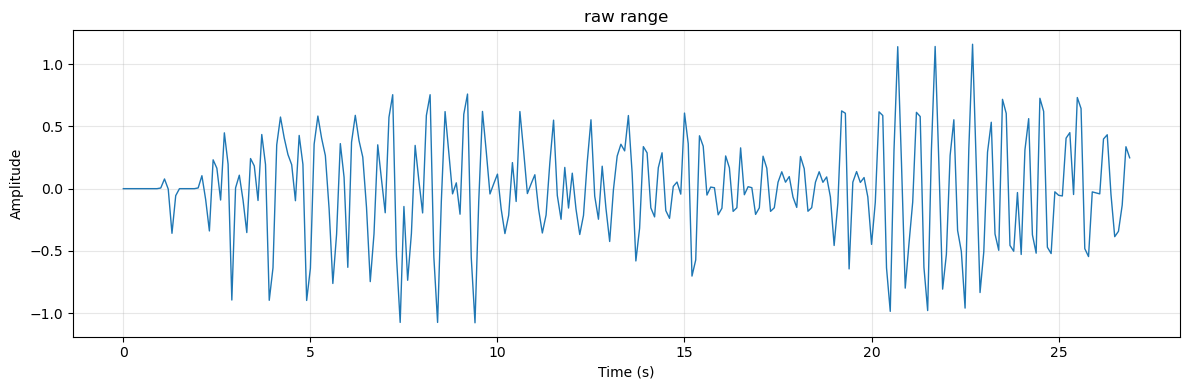

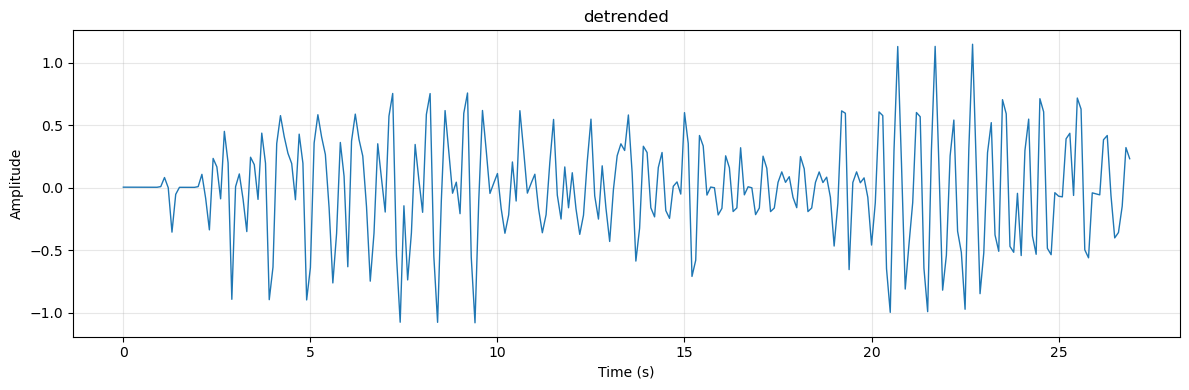

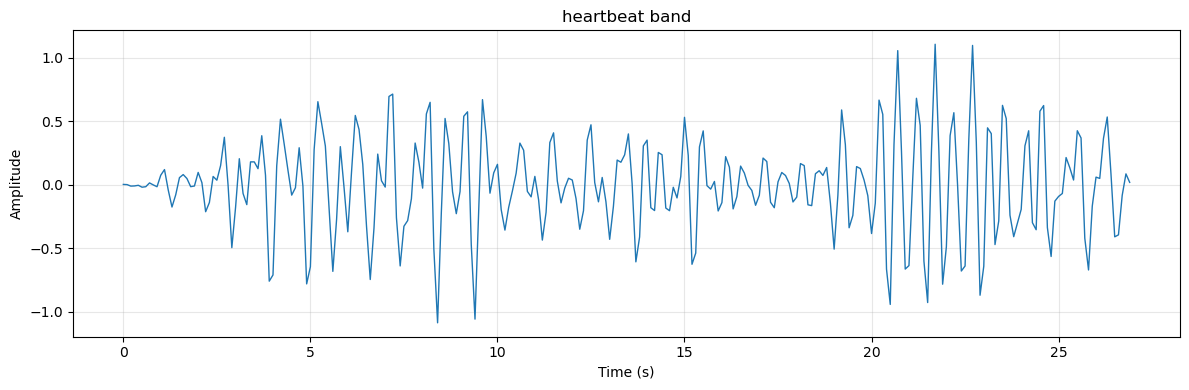

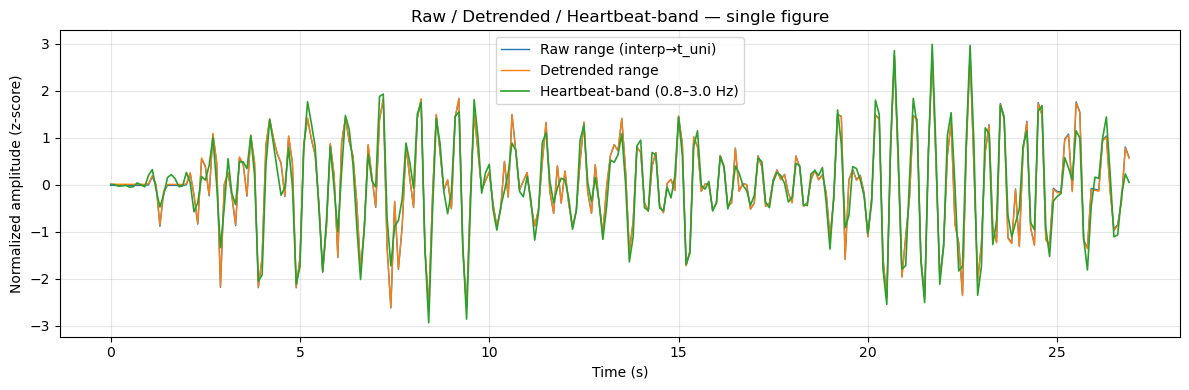

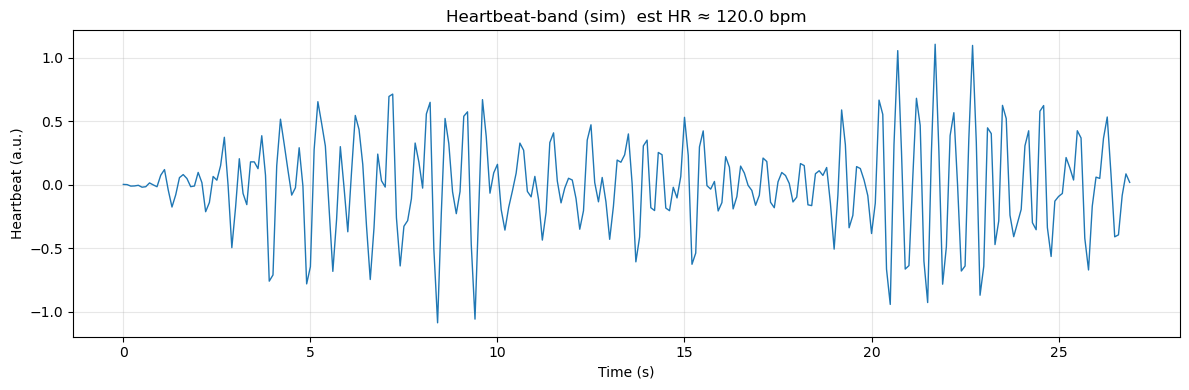

In [ ]:
def process_simulated_summary(sim_summary, outdir="outputs", fs_hint=10.0):
    import os
    os.makedirs(outdir, exist_ok=True)

    # 讀模擬 summary
    df = sim_summary["dataframe"]
    fs0 = float(sim_summary["fs_Hz"])
    t_raw = df["t_sec"].to_numpy()
    r_raw = df["heartbeat"].to_numpy()

    # 與真實流程一致：重取樣 → 去趨勢 → 帶通
    fs, t_uni, r_uni = resample_uniform(t_raw, r_raw, fs_hint=fs_hint or fs0)
    r_detr = signal.detrend(r_uni, type="linear")
    heart  = bandpass(r_detr, fs, 0.8, 3.0)

    # HR 估計
    hr_bpm = estimate_rate(heart, fs, 40, 180)

    # 組新的 summary（與真實版欄位相同）
    csv_path = os.path.join(outdir, "heart_rate_series_sim.csv")
    result_df = pd.DataFrame({
        "t_sec": t_uni,
        "range_detrended": r_detr,
        "heartbeat": heart
    })
    result_df.to_csv(csv_path, index=False)

    summary2 = {
        "samples": int(len(t_uni)),
        "duration_s": float(t_uni[-1] - t_uni[0]),
        "fs_Hz": float(fs),
        "est_hr_bpm": float(hr_bpm) if np.isfinite(hr_bpm) else None,
        "csv": csv_path,
        "heartbeat_png": os.path.join(outdir, "heartbeat_sim.png"),
        "dataframe": result_df
    }

    # 圖：三聯圖 + 疊圖 + 心跳單圖
    plot_waveforms_triple(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir)
    plot_waveforms_overlay(t_raw, r_raw, t_uni, r_detr, heart, outdir=outdir, normalize=True)

    plt.figure(figsize=(12,4))
    ttl = f"Heartbeat-band (sim)  est HR ≈ {hr_bpm:.1f} bpm" if np.isfinite(hr_bpm) else "Heartbeat-band (sim)"
    plt.plot(t_uni, heart, linewidth=1)
    plt.xlabel("Time (s)"); plt.ylabel("Heartbeat (a.u.)")
    plt.title(ttl); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(summary2["heartbeat_png"], dpi=200); plt.show()

    return summary2

# ===== 使用：把你的模擬 summary 丟進相同流程 =====
sim_summary2 = process_simulated_summary(summary, outdir="outputs")




Spectrum Analysis
Signal length: 270 samples
Duration: 26.9 sec
Sampling rate: 10.0 Hz

1) FFT...
   Dominant frequency (within 40-180 bpm): 124.4 bpm (2.074 Hz)
   Difference vs. peak detection: 4.4 bpm



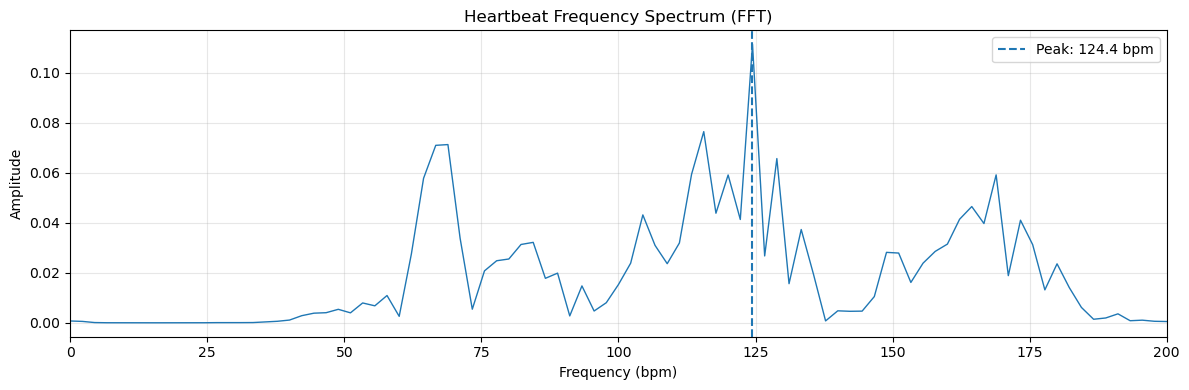

2) Spectrogram...
   Time res: 4.00 s  |  Freq res: 7.50 bpm



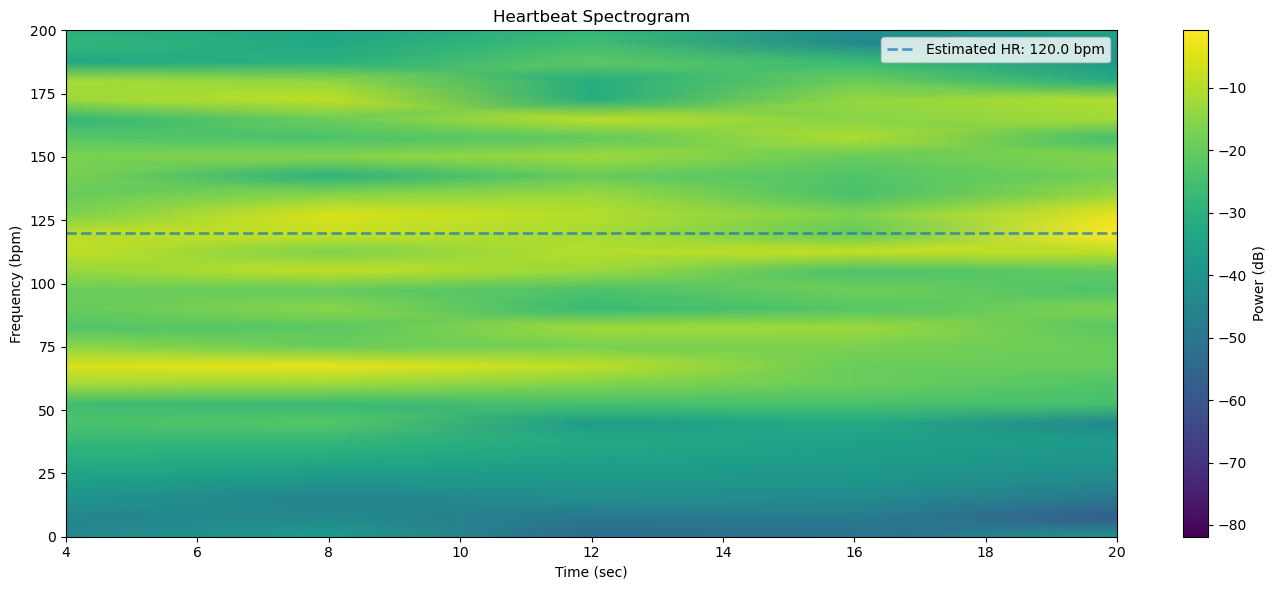

3) Band energy...
   Very Low (<40 bpm)  :                                                      0.0%
   Low (40-60 bpm)     :                                                      0.4%
   Normal (60-100 bpm) : ████████████                                        25.5%
   High (100-120 bpm)  : ██████████                                          20.9%
   Very High (>120 bpm): ██████████████████████████                          53.2%



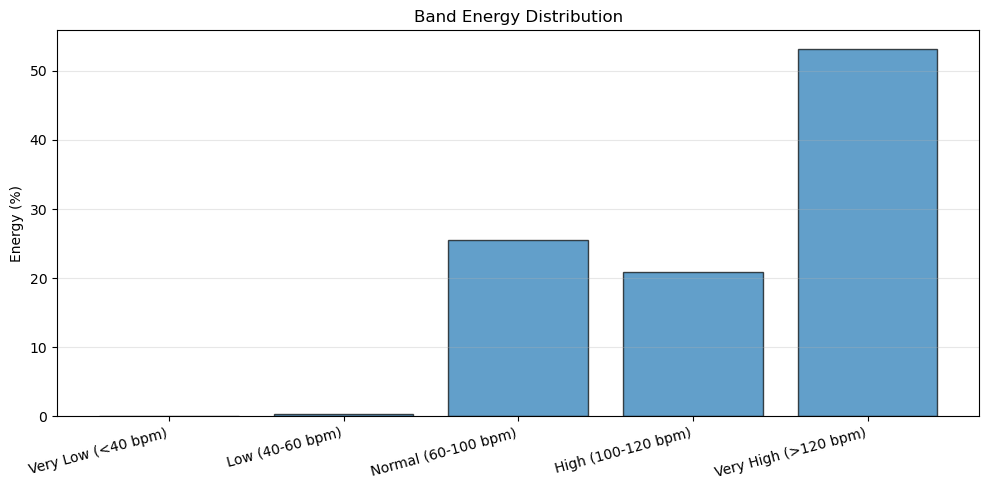

In [9]:
"""
Spectrum Analysis Block - Run in another Notebook cell

Usage:
1. First run the main processing to get summary
2. Then run this block to perform spectrum analysis

Example:
    summary = process_vitals_folder("data/json_logs")
    # Then run the analysis below
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


def analyze_spectrum(summary, save_plots=True, outdir=None,
                     bpm_min=40, bpm_max=180, welch_win_sec=8.0):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import signal

    # ---- get data
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    x = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])

    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')

    n = len(x)
    if n < 16:
        raise ValueError("signal too short")

    # ---- preproc: detrend + window
    x = signal.detrend(x, type="linear")
    w = np.hanning(n)
    xw = x * w
    # 能量保真正規化
    xw = xw / (w.sum() + 1e-12)

    print("="*60)
    print("Spectrum Analysis")
    print("="*60)
    print(f"Signal length: {n} samples")
    print(f"Duration: {t_sec[-1] - t_sec[0]:.1f} sec")
    print(f"Sampling rate: {fs:.1f} Hz\n")

    # ==================== 1) FFT spectrum ====================
    print("1) FFT...")
    freq = np.fft.rfftfreq(n, 1.0/fs)
    fft_vals = np.abs(np.fft.rfft(xw))
    freq_bpm = freq * 60.0

    # 只在生理合理區間找峰
    mask = (freq_bpm >= bpm_min) & (freq_bpm <= bpm_max)
    if not np.any(mask):
        raise ValueError("no bins in bpm range")
    idx_local = np.argmax(fft_vals[mask])
    idx_max = np.flatnonzero(mask)[idx_local]

    dominant_freq_hz = float(freq[idx_max])
    dominant_freq_bpm = float(freq_bpm[idx_max])

    est_hr_from_summary = summary.get('est_hr_bpm', None)
    diff_bpm = (abs(dominant_freq_bpm - float(est_hr_from_summary))
                if est_hr_from_summary is not None and np.isfinite(est_hr_from_summary)
                else np.nan)

    print(f"   Dominant frequency (within {bpm_min}-{bpm_max} bpm): "
          f"{dominant_freq_bpm:.1f} bpm ({dominant_freq_hz:.3f} Hz)")
    if np.isfinite(diff_bpm):
        print(f"   Difference vs. peak detection: {diff_bpm:.1f} bpm")
    print()

    # plot FFT
    plt.figure(figsize=(12, 4))
    plt.plot(freq_bpm, fft_vals, linewidth=1)
    plt.axvline(dominant_freq_bpm, linestyle='--',
                label=f'Peak: {dominant_freq_bpm:.1f} bpm')
    plt.xlabel("Frequency (bpm)"); plt.ylabel("Amplitude")
    plt.title("Heartbeat Frequency Spectrum (FFT)")
    plt.xlim([0, 200]); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout()
    if save_plots:
        spectrum_path = f"{outdir}/spectrum.png"
        plt.savefig(spectrum_path, dpi=200)
        print(f"Saved spectrum plot: {spectrum_path}")
    plt.show()

    # ==================== 2) Spectrogram (Welch參數一致化) ====================
    print("2) Spectrogram...")
    nperseg = int(min(max(welch_win_sec*fs, 64), n//2))
    f, t_spec, Sxx = signal.spectrogram(x, fs, nperseg=nperseg, noverlap=int(0.5*nperseg))
    f_bpm = f * 60.0
    Sxx_db = 10*np.log10(Sxx + 1e-12)

    print(f"   Time res: {t_spec[1]-t_spec[0]:.2f} s  |  Freq res: {(f_bpm[1]-f_bpm[0]):.2f} bpm\n")

    plt.figure(figsize=(14, 6))
    im = plt.pcolormesh(t_spec, f_bpm, Sxx_db, shading='gouraud')
    cbar = plt.colorbar(im, label='Power (dB)')
    plt.ylabel('Frequency (bpm)'); plt.xlabel('Time (sec)')
    plt.title('Heartbeat Spectrogram'); plt.ylim([0, 200])
    if est_hr_from_summary is not None and np.isfinite(est_hr_from_summary):
        plt.axhline(est_hr_from_summary, linestyle='--', linewidth=2, alpha=0.7,
                    label=f"Estimated HR: {est_hr_from_summary:.1f} bpm")
        plt.legend(loc='upper right')
    plt.tight_layout()
    if save_plots:
        spectrogram_path = f"{outdir}/spectrogram.png"
        plt.savefig(spectrogram_path, dpi=200)
        print(f"Saved spectrogram plot: {spectrogram_path}")
    plt.show()

    # ==================== 3) Band energy ====================
    print("3) Band energy...")
    bands = {
        "Very Low (<40 bpm)": (0, 40),
        "Low (40-60 bpm)": (40, 60),
        "Normal (60-100 bpm)": (60, 100),
        "High (100-120 bpm)": (100, 120),
        "Very High (>120 bpm)": (120, 200)
    }
    band_energy = {}
    # 用未加遮罩的全頻 fft_vals，但請注意 peak 搜索已限 40–180
    for name, (lo, hi) in bands.items():
        m = (freq_bpm >= lo) & (freq_bpm < hi)
        band_energy[name] = float(np.sum(fft_vals[m]**2))
    total = sum(band_energy.values()) + 1e-12
    band_percentage = {k: 100.0*v/total for k, v in band_energy.items()}

    for name, pct in band_percentage.items():
        bar = "█" * int(pct/2)
        print(f"   {name:20s}: {bar:50s} {pct:5.1f}%")
    print()

    plt.figure(figsize=(10, 5))
    plt.bar(list(band_percentage.keys()), list(band_percentage.values()), alpha=0.7, edgecolor='black')
    plt.ylabel('Energy (%)'); plt.title('Band Energy Distribution')
    plt.xticks(rotation=15, ha='right'); plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    if save_plots:
        energy_path = f"{outdir}/energy_distribution.png"
        plt.savefig(energy_path, dpi=200)
        print(f"Saved energy distribution plot: {energy_path}")
    plt.show()

    results = {
        "dominant_freq_bpm": dominant_freq_bpm,
        "dominant_freq_hz": dominant_freq_hz,
        "freq_bpm": freq_bpm,
        "fft_amplitude": fft_vals,
        "spectrogram_time": t_spec,
        "spectrogram_freq": f_bpm,
        "spectrogram_power": Sxx_db,
        "band_energy_percentage": band_percentage
    }
    print("="*60 + "\n")
    return results


# ==================== 使用範例 ====================
# 在主程式執行後，使用此函數進行頻譜分析:
#
# summary = process_vitals_folder("data/json_logs")
spectrum_results = analyze_spectrum(sim_summary2, save_plots=False)
#
# # 存取頻譜資料
# print(f"主要頻率: {spectrum_results['dominant_freq_bpm']:.1f} bpm")
# print(f"正常心率能量佔比: {spectrum_results['band_energy_percentage']['正常 (60-100 bpm)']:.1f}%")

Cepstrum Analysis
Global HR estimate from cepstrum: 60.0 bpm
Track HR: mean=53.9 bpm, std=11.7 bpm
Quefrency search window: [0.300, 1.500] s  (HR 40-200 bpm)
Liftering: q < 0.100 s set to 0


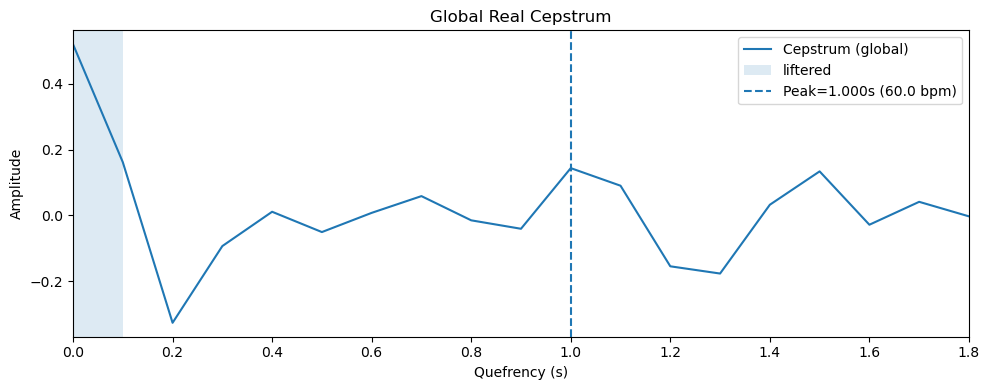

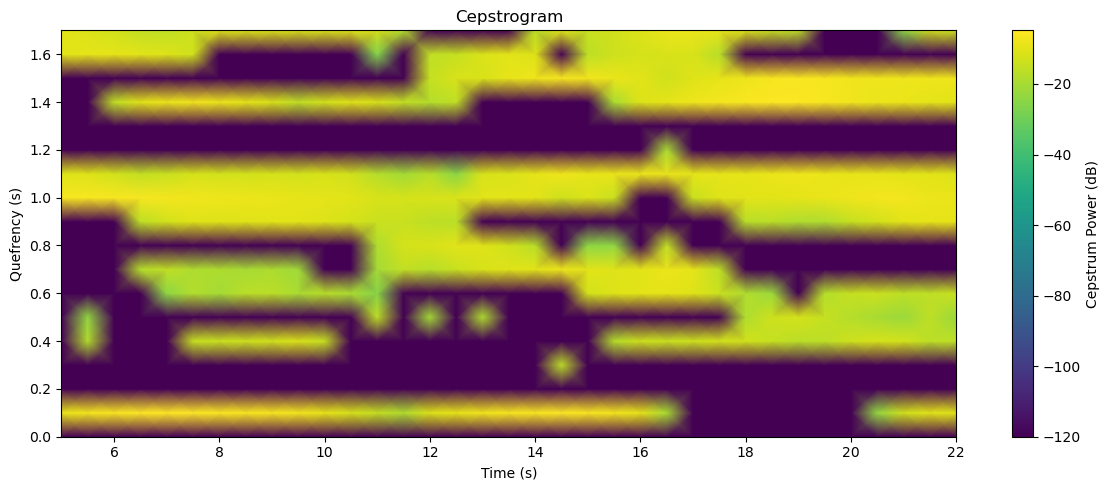

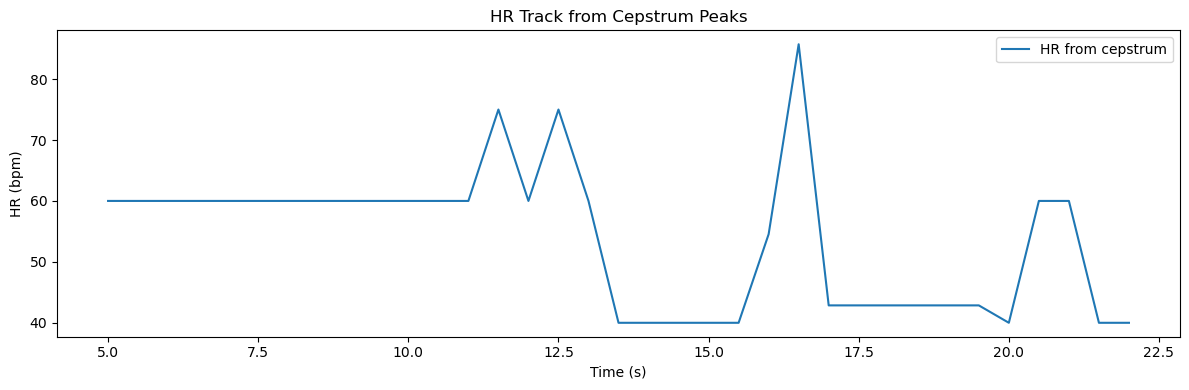

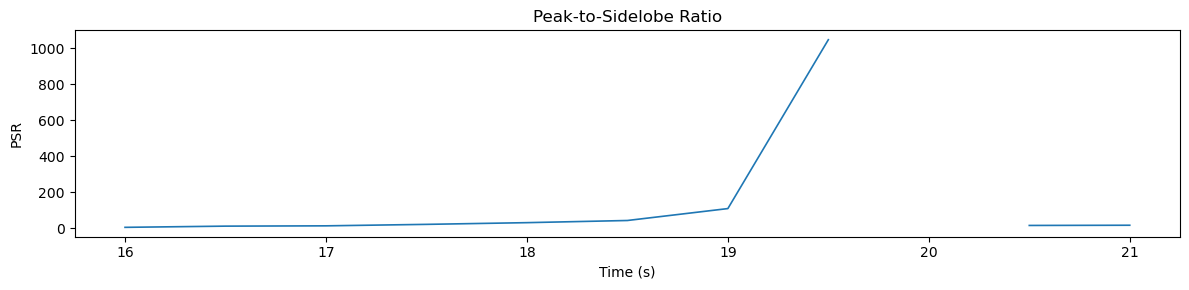

Sim global HR (cepstrum): 60.0


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def analyze_cepstrum(summary,
                     save_plots=True,
                     outdir=None,
                     hr_range_bpm=(40, 200),
                     lifter_q_sec=0.10,
                     win_sec=10.0,
                     hop_sec=0.5,
                     eps=1e-12):
    df = summary['dataframe']
    t_sec = df['t_sec'].values
    x = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])
    if outdir is None:
        outdir = summary.get('csv', 'outputs').replace('heart_rate_series.csv', '').rstrip('/')

    N = len(x)
    hr_lo, hr_hi = hr_range_bpm
    q_lo = 60.0 / hr_hi
    q_hi = 60.0 / hr_lo

    # ---------- 全段倒頻譜（使用 N 長度窗，nfft 取 >= N 的 2 次方） ----------
    nfft_global = int(2 ** np.ceil(np.log2(max(16, N))))
    w_glob = signal.windows.hann(N, sym=False)
    Xg = np.fft.rfft(x * w_glob, n=nfft_global)
    Lg = np.log(np.maximum(np.abs(Xg), eps))
    c_global = np.real(np.fft.irfft(Lg, n=nfft_global))
    q_axis_g = np.arange(nfft_global) / fs

    # liftering 與 HR 搜尋窗
    c_glift = c_global.copy()
    c_glift[q_axis_g < lifter_q_sec] = 0.0
    mask_hr_q_g = (q_axis_g >= max(q_lo, lifter_q_sec)) & (q_axis_g <= q_hi)
    q_star_global = q_axis_g[mask_hr_q_g][np.argmax(c_glift[mask_hr_q_g])]
    hr_global = 60.0 / q_star_global

    # ---------- 滑動窗參數（不超過訊號長度） ----------
    win_len = int(round(win_sec * fs))
    hop_len = int(round(hop_sec * fs))
    if win_len > N:
        win_len = N
    if hop_len < 1:
        hop_len = 1
    if win_len < 4:
        raise ValueError("win_sec too short given fs and signal length.")

    nfft_win = int(2 ** np.ceil(np.log2(max(16, win_len))))
    q_axis_w = np.arange(nfft_win) / fs
    mask_hr_q_w = (q_axis_w >= max(q_lo, lifter_q_sec)) & (q_axis_w <= q_hi)

    # ---------- 逐窗 cepstrogram 與 HR 軌跡 ----------
    w = signal.windows.hann(win_len, sym=False)
    centers, q_peaks, hr_track, conf_psr, frames = [], [], [], [], []

    for start in range(0, max(1, N - win_len + 1), hop_len):
        seg = x[start:start + win_len]
        if len(seg) < win_len:
            break
        Xw = np.fft.rfft(seg * w, n=nfft_win)
        Lw = np.log(np.maximum(np.abs(Xw), eps))
        c = np.real(np.fft.irfft(Lw, n=nfft_win))

        # liftering
        c[q_axis_w < lifter_q_sec] = 0.0

        # HR 對應 quefrency 主峰
        c_hr = np.where(mask_hr_q_w, c, 0.0)
        pk_idx = int(np.argmax(c_hr))
        q_pk = q_axis_w[pk_idx]
        hr = 60.0 / q_pk

        # PSR（主峰對旁瓣比）
        sl_mask = mask_hr_q_w.copy()
        win_ex = 2
        sl_mask[max(0, pk_idx - win_ex):min(len(sl_mask), pk_idx + win_ex + 1)] = False
        sidelobe = np.mean(c[sl_mask]) if np.any(sl_mask) else 0.0
        psr = (c[pk_idx] / (sidelobe + 1e-9)) if sidelobe > 0 else np.inf

        centers.append(t_sec[min(start + win_len // 2, N - 1)])
        q_peaks.append(q_pk)
        hr_track.append(hr)
        conf_psr.append(psr)
        frames.append(c)

    centers = np.asarray(centers)
    q_peaks = np.asarray(q_peaks)
    hr_track = np.asarray(hr_track)
    conf_psr = np.asarray(conf_psr)
    cepstrogram = np.stack(frames, axis=1) if len(frames) else np.zeros((nfft_win, 0))

    # ---------- 視覺化 ----------
    print("=" * 60)
    print("Cepstrum Analysis")
    print("=" * 60)
    print(f"Global HR estimate from cepstrum: {hr_global:.1f} bpm")
    if len(hr_track):
        print(f"Track HR: mean={np.nanmean(hr_track):.1f} bpm, std={np.nanstd(hr_track):.1f} bpm")
    print(f"Quefrency search window: [{q_lo:.3f}, {q_hi:.3f}] s  (HR {hr_lo}-{hr_hi} bpm)")
    print(f"Liftering: q < {lifter_q_sec:.3f} s set to 0")

    # 全段
    plt.figure(figsize=(10, 4))
    plt.plot(q_axis_g, c_global, label="Cepstrum (global)")
    plt.axvspan(0, lifter_q_sec, alpha=0.15, label="liftered")
    plt.axvline(q_star_global, linestyle='--', label=f'Peak={q_star_global:.3f}s ({hr_global:.1f} bpm)')
    plt.xlim(0, min(2.0, q_hi * 1.2))
    plt.xlabel("Quefrency (s)"); plt.ylabel("Amplitude"); plt.title("Global Real Cepstrum")
    plt.legend(); plt.tight_layout()
    if save_plots: plt.savefig(f"{outdir}/cepstrum_global.png", dpi=200)
    plt.show()

    # cepstrogram
    if cepstrogram.shape[1] > 0:
        q_max_plot = min(2.0, q_hi * 1.2)
        q_mask_plot = q_axis_w <= q_max_plot
        C_db = 10 * np.log10(np.maximum(cepstrogram[q_mask_plot, :], eps))
        plt.figure(figsize=(12, 5))
        im = plt.pcolormesh(centers, q_axis_w[q_mask_plot], C_db, shading='gouraud')
        plt.colorbar(im, label='Cepstrum Power (dB)')
        plt.xlabel("Time (s)"); plt.ylabel("Quefrency (s)"); plt.title("Cepstrogram")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrogram.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 4))
        plt.plot(centers, hr_track, linewidth=1.5, label="HR from cepstrum")
        if summary.get('est_hr_bpm') and np.isfinite(summary['est_hr_bpm']):
            plt.axhline(summary['est_hr_bpm'], linestyle='--',
                        label=f"Est. HR (summary) {summary['est_hr_bpm']:.1f} bpm")
        plt.xlabel("Time (s)"); plt.ylabel("HR (bpm)"); plt.title("HR Track from Cepstrum Peaks")
        plt.legend(); plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/hr_track_cepstrum.png", dpi=200)
        plt.show()

        plt.figure(figsize=(12, 3))
        plt.plot(centers, conf_psr, linewidth=1.2)
        plt.xlabel("Time (s)"); plt.ylabel("PSR"); plt.title("Peak-to-Sidelobe Ratio")
        plt.tight_layout()
        if save_plots: plt.savefig(f"{outdir}/cepstrum_confidence_psr.png", dpi=200)
        plt.show()

    return {
        "q_axis_global_sec": q_axis_g,
        "cepstrum_global": c_global,
        "q_star_global_sec": float(q_star_global),
        "hr_global_bpm": float(hr_global),
        "q_axis_win_sec": q_axis_w,
        "centers_sec": centers,
        "cepstrogram": cepstrogram,
        "q_peak_track_sec": q_peaks,
        "hr_track_bpm": hr_track,
        "confidence_psr": conf_psr,
        "params": {
            "fs_Hz": fs, "win_sec": win_sec, "hop_sec": hop_sec,
            "hr_range_bpm": hr_range_bpm, "lifter_q_sec": lifter_q_sec,
            "nfft_global": nfft_global, "nfft_win": nfft_win
        }
    }

# 後續與真實資料相同的分析
cep_results = analyze_cepstrum(summary, save_plots=False)
print("Sim global HR (cepstrum):", cep_results["hr_global_bpm"])

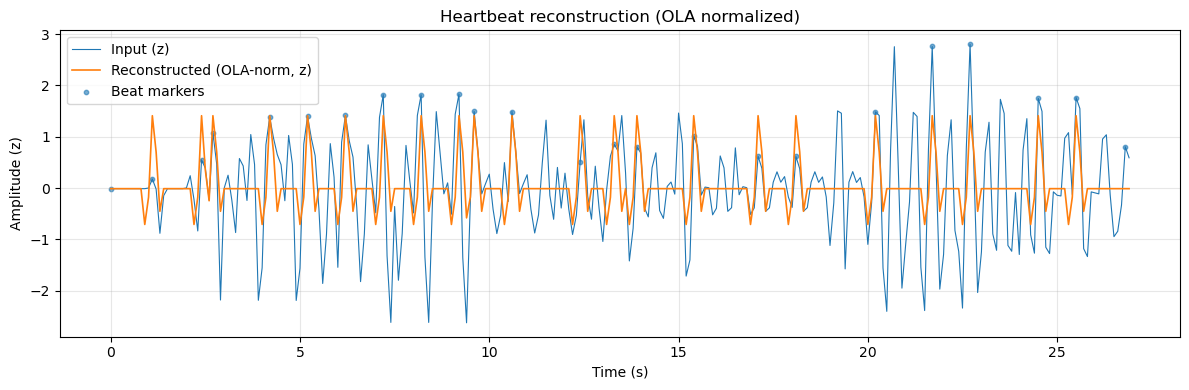

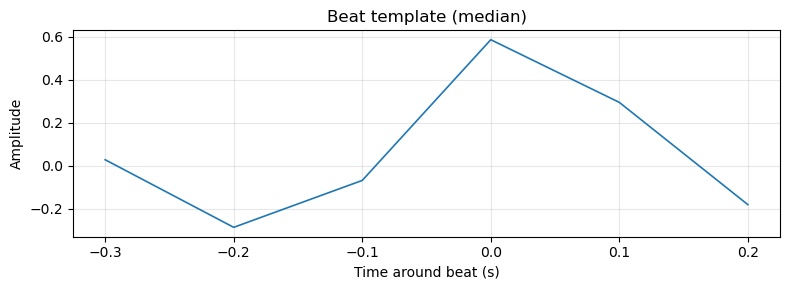

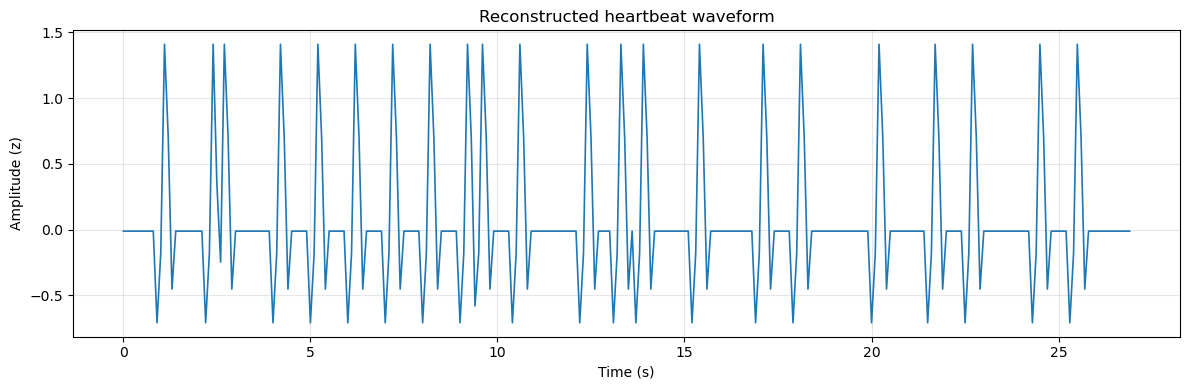

IBI mean (s): 1.1652173913043478 HR mean (bpm): 63.2196533219551


In [11]:
import numpy as np
from scipy import signal, interpolate
import matplotlib.pyplot as plt

def reconstruct_heartbeat_from_cepstrum(summary, cep_results,
                                        peak_search_halfwin=0.35,
                                        template_win=0.6,
                                        show_plots=True):
    """
    Reconstruct heartbeat via cepstrum-guided cycle-synchronous averaging (CSA).
    Applies OLA normalization to prevent inflated peaks.
    """
    df = summary['dataframe']
    t  = df['t_sec'].values
    y  = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])

    centers = np.asarray(cep_results["centers_sec"])
    q_pk    = np.asarray(cep_results["q_peak_track_sec"])  # IBI (s)
    if centers.size == 0 or q_pk.size == 0:
        raise ValueError("No cepstrum track. Run analyze_cepstrum first.")

    # --- build beat timeline from IBI track ---
    ibi_f = interpolate.interp1d(centers, q_pk, kind="linear",
                                 bounds_error=False, fill_value=(q_pk[0], q_pk[-1]))
    beats = [centers[0]]
    t_cur = centers[0]
    while t_cur < t[-1] - 0.3:
        t_cur = t_cur + float(ibi_f(t_cur))
        beats.append(t_cur)
    t_cur = centers[0]
    left = []
    while t_cur > t[0] + 0.3:
        t_cur = t_cur - float(ibi_f(t_cur))
        left.append(t_cur)
    beats = np.array(sorted(left[::-1] + beats))

    # --- local refinement around each predicted beat ---
    half_samp = max(1, int(round(peak_search_halfwin * fs)))
    adj_beats = []
    for tb in beats:
        i  = int(np.searchsorted(t, tb))
        i0 = max(0, i - half_samp); i1 = min(len(y)-1, i + half_samp)
        if i1 <= i0 + 2: 
            continue
        loc = i0 + np.argmax(y[i0:i1+1])
        adj_beats.append(t[loc])
    adj_beats = np.asarray(adj_beats)

    # --- CSA template ---
    L = int(round(template_win * fs))
    halfL = L // 2
    segs, idx_keep = [], []
    for tb in adj_beats:
        i  = int(np.searchsorted(t, tb))
        i0 = i - halfL; i1 = i - halfL + L
        if i0 < 0 or i1 > len(y): 
            continue
        segs.append(y[i0:i1]); idx_keep.append(i)
    if not segs:
        raise ValueError("No valid segments for CSA. Adjust template_win.")
    segs = np.stack(segs, axis=0)
    template = np.median(segs, axis=0)

    # --- OLA with normalization (fix #1) ---
    y_rec = np.zeros_like(y, float)
    w_ov  = signal.windows.hann(L, sym=False)
    w_sum = np.zeros_like(y, float)
    for i in idx_keep:
        i0 = i - halfL; i1 = i - halfL + L
        y_rec[i0:i1] += template * w_ov
        w_sum[i0:i1] += w_ov
    y_rec /= np.maximum(w_sum, 1e-12)  # normalize overlap

    # --- outputs and optional plots ---
    if show_plots:
        z  = (y - y.mean())/(y.std()+1e-12)
        zr = (y_rec - y.mean())/(y.std()+1e-12)  # align scale to input
        plt.figure(figsize=(12,4))
        plt.plot(t, z,  lw=0.8, label="Input (z)")
        plt.plot(t, zr, lw=1.2, label="Reconstructed (OLA-norm, z)")
        plt.scatter(adj_beats, np.interp(adj_beats, t, z), s=10, alpha=0.6, label="Beat markers")
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude (z)")
        plt.title("Heartbeat reconstruction (OLA normalized)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(8,3))
        tt = np.arange(L)/fs - (halfL/fs)
        plt.plot(tt, template, lw=1.2)
        plt.xlabel("Time around beat (s)"); plt.ylabel("Amplitude")
        plt.title("Beat template (median)"); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

        adj_beats = np.sort(adj_beats)
        ibi = np.diff(adj_beats)
        valid = (ibi >= 0.3) & (ibi <= 2.5)   # 24–200 bpm
        ibi = ibi[valid]
        hr_inst = 60.0 / np.clip(ibi, 1e-6, None)

    return {
        "beat_times_sec": adj_beats,
        "ibi_sec": ibi,
        "hr_inst_bpm": hr_inst,
        "template": template,
        "template_time_sec": (np.arange(L)/fs - (halfL/fs)),
        "reconstructed": y_rec
    }

def plot_reconstructed_only(summary, rec, normalize=True):
    t = summary['dataframe']['t_sec'].values
    y = rec['reconstructed'].astype(float)
    if normalize:
        base = summary['dataframe']['heartbeat'].values
        y = (y - base.mean())/(base.std()+1e-12)
    plt.figure(figsize=(12,4))
    plt.plot(t, y, lw=1.2)
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude" + (" (z)" if normalize else ""))
    plt.title("Reconstructed heartbeat waveform"); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
#cep_results = analyze_cepstrum(summary, save_plots=False)
rec = reconstruct_heartbeat_from_cepstrum(summary, cep_results, show_plots=True)
plot_reconstructed_only(summary, rec, normalize=True)
print("IBI mean (s):", rec["ibi_sec"].mean(), "HR mean (bpm):", rec["hr_inst_bpm"].mean())



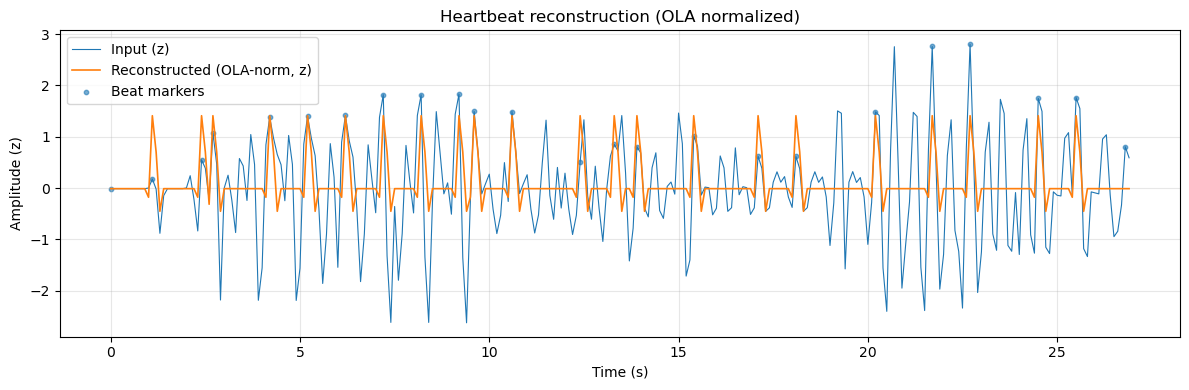

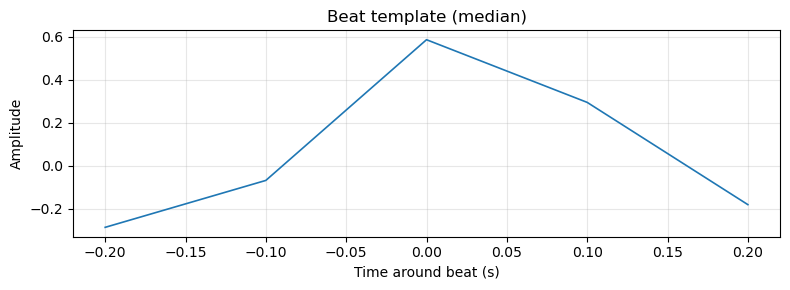

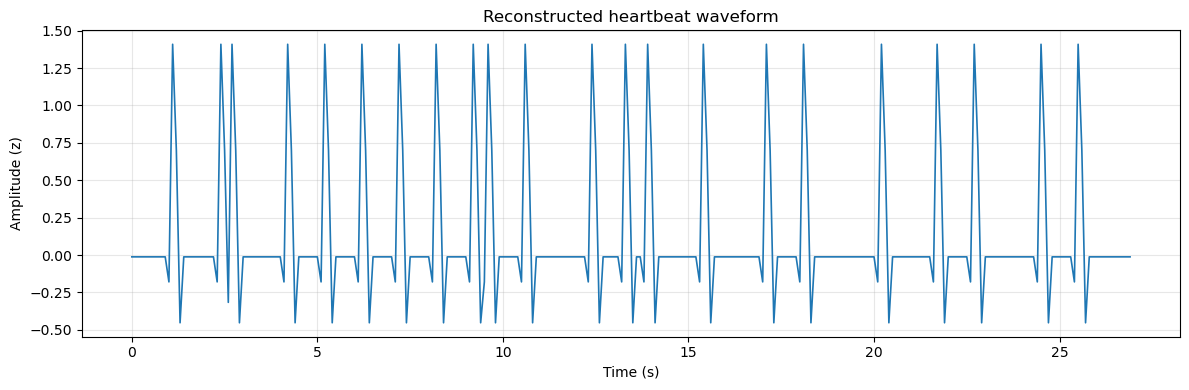

IBI mean (s): 1.1652173913043478 HR mean (bpm): 63.2196533219551


In [18]:
import numpy as np
from scipy import signal, interpolate
import matplotlib.pyplot as plt

def reconstruct_heartbeat_from_cepstrum(summary, cep_results,
                                        peak_search_halfwin=0.45,
                                        template_win=0.5,
                                        show_plots=True):
    """
    Reconstruct heartbeat via cepstrum-guided cycle-synchronous averaging (CSA).
    Applies OLA normalization to prevent inflated peaks.
    """
    df = summary['dataframe']
    t  = df['t_sec'].values
    y  = df['heartbeat'].values.astype(float)
    fs = float(summary['fs_Hz'])

    centers = np.asarray(cep_results["centers_sec"])
    q_pk    = np.asarray(cep_results["q_peak_track_sec"])  # IBI (s)
    if centers.size == 0 or q_pk.size == 0:
        raise ValueError("No cepstrum track. Run analyze_cepstrum first.")

    # --- build beat timeline from IBI track ---
    ibi_f = interpolate.interp1d(centers, q_pk, kind="linear",
                                 bounds_error=False, fill_value=(q_pk[0], q_pk[-1]))
    beats = [centers[0]]
    t_cur = centers[0]
    while t_cur < t[-1] - 0.3:
        t_cur = t_cur + float(ibi_f(t_cur))
        beats.append(t_cur)
    t_cur = centers[0]
    left = []
    while t_cur > t[0] + 0.3:
        t_cur = t_cur - float(ibi_f(t_cur))
        left.append(t_cur)
    beats = np.array(sorted(left[::-1] + beats))

    # --- local refinement around each predicted beat ---
    half_samp = max(1, int(round(peak_search_halfwin * fs)))
    adj_beats = []
    for tb in beats:
        i  = int(np.searchsorted(t, tb))
        i0 = max(0, i - half_samp); i1 = min(len(y)-1, i + half_samp)
        if i1 <= i0 + 2: 
            continue
        loc = i0 + np.argmax(y[i0:i1+1])
        adj_beats.append(t[loc])
    adj_beats = np.asarray(adj_beats)

    # --- CSA template ---
    L = int(round(template_win * fs))
    halfL = L // 2
    segs, idx_keep = [], []
    for tb in adj_beats:
        i  = int(np.searchsorted(t, tb))
        i0 = i - halfL; i1 = i - halfL + L
        if i0 < 0 or i1 > len(y): 
            continue
        segs.append(y[i0:i1]); idx_keep.append(i)
    if not segs:
        raise ValueError("No valid segments for CSA. Adjust template_win.")
    segs = np.stack(segs, axis=0)
    template = np.median(segs, axis=0)

    # --- OLA with normalization (fix #1) ---
    y_rec = np.zeros_like(y, float)
    w_ov  = signal.windows.hann(L, sym=False)
    w_sum = np.zeros_like(y, float)
    for i in idx_keep:
        i0 = i - halfL; i1 = i - halfL + L
        y_rec[i0:i1] += template * w_ov
        w_sum[i0:i1] += w_ov
    y_rec /= np.maximum(w_sum, 1e-12)  # normalize overlap

    # --- outputs and optional plots ---
    if show_plots:
        z  = (y - y.mean())/(y.std()+1e-12)
        zr = (y_rec - y.mean())/(y.std()+1e-12)  # align scale to input
        plt.figure(figsize=(12,4))
        plt.plot(t, z,  lw=0.8, label="Input (z)")
        plt.plot(t, zr, lw=1.2, label="Reconstructed (OLA-norm, z)")
        plt.scatter(adj_beats, np.interp(adj_beats, t, z), s=10, alpha=0.6, label="Beat markers")
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude (z)")
        plt.title("Heartbeat reconstruction (OLA normalized)")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(8,3))
        tt = np.arange(L)/fs - (halfL/fs)
        plt.plot(tt, template, lw=1.2)
        plt.xlabel("Time around beat (s)"); plt.ylabel("Amplitude")
        plt.title("Beat template (median)"); plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

        adj_beats = np.sort(adj_beats)
        ibi = np.diff(adj_beats)
        valid = (ibi >= 0.3) & (ibi <= 2.5)   # 24–200 bpm
        ibi = ibi[valid]
        hr_inst = 60.0 / np.clip(ibi, 1e-6, None)

    return {
        "beat_times_sec": adj_beats,
        "ibi_sec": ibi,
        "hr_inst_bpm": hr_inst,
        "template": template,
        "template_time_sec": (np.arange(L)/fs - (halfL/fs)),
        "reconstructed": y_rec
    }

def plot_reconstructed_only(summary, rec, normalize=True):
    t = summary['dataframe']['t_sec'].values
    y = rec['reconstructed'].astype(float)
    if normalize:
        base = summary['dataframe']['heartbeat'].values
        y = (y - base.mean())/(base.std()+1e-12)
    plt.figure(figsize=(12,4))
    plt.plot(t, y, lw=1.2)
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude" + (" (z)" if normalize else ""))
    plt.title("Reconstructed heartbeat waveform"); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
#cep_results = analyze_cepstrum(summary, save_plots=False)
rec = reconstruct_heartbeat_from_cepstrum(summary, cep_results, show_plots=True)
plot_reconstructed_only(summary, rec, normalize=True)
print("IBI mean (s):", rec["ibi_sec"].mean(), "HR mean (bpm):", rec["hr_inst_bpm"].mean())



